In [1]:
#%% Imports

# Basic Imports 
import numpy as np
import pandas as pd

# Plotting Imports
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from networkx import DiGraph
import networkx as nx
import statistics
from itertools import permutations
from itertools import combinations #no longer being used
from IPython import display

In [2]:
curated = pd.read_csv('curated_gene_disease_associations.tsv', sep = "\t")
curated

,geneId,geneSymbol,DSI,DPI,diseaseId,diseaseName,diseaseType,diseaseClass,diseaseSemanticType,score,EI,YearInitial,YearFinal,NofPmids,NofSnps,source
0,1,A1BG,0.700,0.538,C0019209,Hepatomegaly,phenotype,C23;C06,Finding,0.30,1.000,2017.0,2017.0,1,0,CTD_human
1,1,A1BG,0.700,0.538,C0036341,Schizophrenia,disease,F03,Mental or Behavioral Dysfunction,0.30,1.000,2015.0,2015.0,1,0,CTD_human
2,2,A2M,0.529,0.769,C0002395,Alzheimer's Disease,disease,C10;F03,Disease or Syndrome,0.50,0.769,1998.0,2018.0,3,0,CTD_human
3,2,A2M,0.529,0.769,C0007102,Malignant tumor of colon,disease,C06;C04,Neoplastic Process,0.31,1.000,2004.0,2019.0,1,0,CTD_human
4,2,A2M,0.529,0.769,C0009375,Colonic Neoplasms,group,C06;C04,Neoplastic Process,0.30,1.000,2004.0,2004.0,1,0,CTD_human
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84033,109580095,HBB-LCR,0.743,0.115,C0002875,Cooley's anemia,disease,C16;C15,Disease or Syndrome,0.30,NaN,NaN,NaN,0,0,CTD_human
84034,109580095,HBB-LCR,0.743,0.115,C0005283,beta Thalassemia,disease,C16;C15,Disease or Syndrome,0.30,NaN,NaN,NaN,0,0,CTD_human
84035,109580095,HBB-LCR,0.743,0.115,C0019025,Hemoglobin F Disease,disease,C16;C15,Disease or Syndrome,0.30,NaN,NaN,NaN,0,0,CTD_human
84036,109580095,HBB-LCR,0.743,0.115,C0085578,Thalassemia Minor,disease,C16;C15,Disease or Syndrome,0.30,NaN,NaN,NaN,0,0,CTD_human


In [3]:
curated.source.unique()

array(['CTD_human', 'PSYGENET', 'CTD_human;GENOMICS_ENGLAND;UNIPROT',
       'CTD_human;GENOMICS_ENGLAND;ORPHANET;UNIPROT', 'GENOMICS_ENGLAND',
       'CTD_human;UNIPROT', 'CTD_human;GENOMICS_ENGLAND', 'ORPHANET',
       'UNIPROT', 'CTD_human;GENOMICS_ENGLAND;ORPHANET',
       'CGI;CTD_human;ORPHANET', 'CGI;ORPHANET', 'CGI;CTD_human',
       'GENOMICS_ENGLAND;UNIPROT', 'CLINGEN;ORPHANET',
       'CLINGEN;CTD_human;GENOMICS_ENGLAND;UNIPROT',
       'CLINGEN;CTD_human;GENOMICS_ENGLAND;ORPHANET;UNIPROT',
       'CTD_human;ORPHANET', 'CLINGEN;GENOMICS_ENGLAND',
       'GENOMICS_ENGLAND;ORPHANET', 'GENOMICS_ENGLAND;ORPHANET;UNIPROT',
       'CLINGEN', 'CTD_human;PSYGENET',
       'CGI;CTD_human;GENOMICS_ENGLAND;UNIPROT', 'CGI',
       'CGI;CTD_human;GENOMICS_ENGLAND', 'CLINGEN;CTD_human',
       'CLINGEN;UNIPROT', 'CGI;UNIPROT',
       'CLINGEN;CTD_human;GENOMICS_ENGLAND', 'CGI;GENOMICS_ENGLAND',
       'CTD_human;ORPHANET;UNIPROT', 'CGI;GENOMICS_ENGLAND;UNIPROT',
       'CLINGEN;GENOMICS_E

These data contain GDAs provided by the expert curated resources:
- UNIPROT: UniProt/SwissProt is a database containing curated information about protein sequence, structure and function (The UniProt Consortium, 2018). GDAs were obtained from the humsavar file. We include only the associations marked as Disease.

- CTD: The Comparative Toxicogenomics DatabaseTM contains manually curated information about gene-disease relationships with focus on understanding the effects of environmental chemicals on human health (Davis et al., 2018 ). From CTD we only include associations marked as marker/mechanism or therapeutic.

- ORPHANET: Orphanet is the reference portal for information on rare diseases and orphan drugs, for all audiences (© INSERM 1997). Its aim is to help improve the diagnosis, care and treatment of patients with rare diseases. From Orphanet we keep all GDAs.
- CLINGEN: The Clinical Genome Resource is dedicated to building an authoritative central resource that defines the clinical relevance of genes and variants for use in precision medicine and research ( Rehm et al., 2018 ). From ClinGen, we do not include GDAs labeled as "refuted".
- GENOMICS ENGLAND: The Genomics England PanelApp is a publically available knowledge base that allows virtual gene panels related to human disorders to be created, stored and queried. From this source we keep all GDAs.
- CGI: The Cancer Genome Interpreter is a tool that (i) identifies known oncogenic alterations; (ii) predicts potential drivers among those of unknown significance and (iii) identify alterations in the tumor known to affect the response to anti-cancer drugs ( Tamborero et al., 2018 ). It also distributes the catalog of Cancer Driver Genes, which is a selection of genes driving tumorigenesis in a certain tumor type(s) upon a certain alteration (mutation, copy number alteration and/or gene translocation). From this dataset, we only keep validated data and do not include computational predictions.
- PSYGENET: PsyGeNET (Psychiatric disorders Gene association NETwork) is a resource for the exploratory analysis of psychiatric diseases and their associated genes (Gutiérrez-Sacristán et al., 2009 ).


- UNIPROT: database with curated info on protein sequence, structure and function. DisGeNET only included the human gene-disease associations marked as Disease from this database.
- CTD/CTD_human (The Comparative Toxicogenomics Database): database with manually curated info about gene-disease relationships with focus on understanding how environmental exposures affect human health. DisGENET only included the associations marked as marker/mechanism or therapeutic.
- ORPHANET: reference portal for info on rare diseases and orphan drugs to help improve the diagnosis, care, and treatment of patients with rare diseases. All gene-disease associations were kept by DisGeNET.
- CLINGEN (Clinical Genome Resource): resource that defines the clinical relevance of genes and variants for use in precision medicine and research. DisGeNET uses all gene-disease associations exceptthose labeled as 'refuted.'
- GENOMICS ENGLAND (Genomics England PanelApp): knowledge base that allows virtual gene panels related to human disorders to be created, stored, and queried. DisGeNET kept all gene-disease associations.
- CGI (Cancer Genome Interpreter): tool that identifies known brain-tumor-causing alterations, predicts potential drivers among those of unknown significance, and itdentifies alterations in the tumor known to affect the response to anti-cancer drugs. It also has the catalog of Cancer Driver Genes, which is a selection of genes driving tumorigenesis (the formation/production of tumors) in a certain tumor type(s) upon a certain alteration. DisGeNET only kept validated data and not computational predictions.
- PSYGENET (Psychiatric Disorders Gene Association Network): resource for exploratory analysis of psychiatric diseases and their associated diseases. DisGeNet uses all gene-disease associations from here. 

In [3]:
threeCol = curated.drop(columns = ['diseaseType', 'DSI', 'DPI', 'diseaseClass', 'diseaseSemanticType', 'score', 'EI', 'YearInitial', 'YearFinal', 'NofPmids', 'NofSnps'])
threeCol

,geneId,geneSymbol,diseaseId,diseaseName,source
0,1,A1BG,C0019209,Hepatomegaly,CTD_human
1,1,A1BG,C0036341,Schizophrenia,CTD_human
2,2,A2M,C0002395,Alzheimer's Disease,CTD_human
3,2,A2M,C0007102,Malignant tumor of colon,CTD_human
4,2,A2M,C0009375,Colonic Neoplasms,CTD_human
...,...,...,...,...,...
84033,109580095,HBB-LCR,C0002875,Cooley's anemia,CTD_human
84034,109580095,HBB-LCR,C0005283,beta Thalassemia,CTD_human
84035,109580095,HBB-LCR,C0019025,Hemoglobin F Disease,CTD_human
84036,109580095,HBB-LCR,C0085578,Thalassemia Minor,CTD_human


In [11]:
# Dataset with diseaseID, source, and log of Counts of Genes per Disease by Source:
logSumDisease = threeCol.groupby(by = ['diseaseId', 'source']).size().sort_values(ascending=False).reset_index(name = 'Counts of Genes per Disease by Source')
logSumDisease

,diseaseId,source,Counts of Genes per Disease by Source
0,C0023893,CTD_human,774
1,C0036341,PSYGENET,711
2,C0033578,CTD_human,615
3,C0376358,CTD_human,606
4,C0006142,UNIPROT,536
...,...,...,...
14047,C1609433,CTD_human;GENOMICS_ENGLAND;ORPHANET,1
14048,C1609433,CTD_human;ORPHANET,1
14049,C1611706,ORPHANET,1
14050,C1619700,GENOMICS_ENGLAND;UNIPROT,1


In [12]:
logSumDisease['Log of Counts of Genes per Disease by Source'] = np.log10(logSumDisease['Counts of Genes per Disease by Source'])
logSumDisease

,diseaseId,source,Counts of Genes per Disease by Source,Log of Counts of Genes per Disease by Source
0,C0023893,CTD_human,774,2.888741
1,C0036341,PSYGENET,711,2.851870
2,C0033578,CTD_human,615,2.788875
3,C0376358,CTD_human,606,2.782473
4,C0006142,UNIPROT,536,2.729165
...,...,...,...,...
14047,C1609433,CTD_human;GENOMICS_ENGLAND;ORPHANET,1,0.000000
14048,C1609433,CTD_human;ORPHANET,1,0.000000
14049,C1611706,ORPHANET,1,0.000000
14050,C1619700,GENOMICS_ENGLAND;UNIPROT,1,0.000000


## Boxplot of Counts of Genes per Disease for each Source:

<AxesSubplot:xlabel='Counts of Genes per Disease by Source', ylabel='source'>

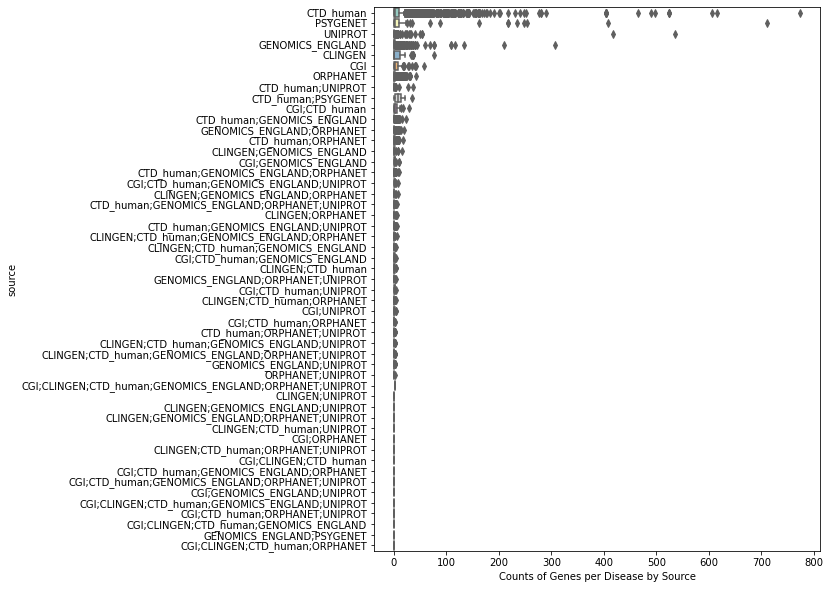

In [13]:
fig, ax = plt.subplots(figsize = (8,10))
sns.boxplot(y = 'source', x = 'Counts of Genes per Disease by Source',
                 data = logSumDisease, palette="Set3", orient = 'h')

### Noticing that the sources were already grouped together, I will separate them:

In [4]:
threeCol['source'] = threeCol['source'].apply(lambda x: set(x[:].split(";")))

In [5]:
threeCol

,geneId,geneSymbol,diseaseId,diseaseName,source
0,1,A1BG,C0019209,Hepatomegaly,{CTD_human}
1,1,A1BG,C0036341,Schizophrenia,{CTD_human}
2,2,A2M,C0002395,Alzheimer's Disease,{CTD_human}
3,2,A2M,C0007102,Malignant tumor of colon,{CTD_human}
4,2,A2M,C0009375,Colonic Neoplasms,{CTD_human}
...,...,...,...,...,...
84033,109580095,HBB-LCR,C0002875,Cooley's anemia,{CTD_human}
84034,109580095,HBB-LCR,C0005283,beta Thalassemia,{CTD_human}
84035,109580095,HBB-LCR,C0019025,Hemoglobin F Disease,{CTD_human}
84036,109580095,HBB-LCR,C0085578,Thalassemia Minor,{CTD_human}


In [6]:
threeColsep = pd.DataFrame([(c, tup.geneId, tup.geneSymbol, tup.diseaseId, tup.diseaseName) for tup in threeCol.itertuples() for c in tup.source])
threeColsep

,0,1,2,3,4
0,CTD_human,1,A1BG,C0019209,Hepatomegaly
1,CTD_human,1,A1BG,C0036341,Schizophrenia
2,CTD_human,2,A2M,C0002395,Alzheimer's Disease
3,CTD_human,2,A2M,C0007102,Malignant tumor of colon
4,CTD_human,2,A2M,C0009375,Colonic Neoplasms
...,...,...,...,...,...
96920,CTD_human,109580095,HBB-LCR,C0002875,Cooley's anemia
96921,CTD_human,109580095,HBB-LCR,C0005283,beta Thalassemia
96922,CTD_human,109580095,HBB-LCR,C0019025,Hemoglobin F Disease
96923,CTD_human,109580095,HBB-LCR,C0085578,Thalassemia Minor


In [7]:
threeColsep[0].unique()

array(['CTD_human', 'PSYGENET', 'UNIPROT', 'GENOMICS_ENGLAND', 'ORPHANET',
       'CGI', 'CLINGEN'], dtype=object)

In [7]:
threeColsep = threeColsep.rename(columns= {0: 'source', 1: 'geneId', 2: 'geneSymbol', 3: 'diseaseId', 4: 'diseaseName'})
threeColsep

,source,geneId,geneSymbol,diseaseId,diseaseName
0,CTD_human,1,A1BG,C0019209,Hepatomegaly
1,CTD_human,1,A1BG,C0036341,Schizophrenia
2,CTD_human,2,A2M,C0002395,Alzheimer's Disease
3,CTD_human,2,A2M,C0007102,Malignant tumor of colon
4,CTD_human,2,A2M,C0009375,Colonic Neoplasms
...,...,...,...,...,...
96920,CTD_human,109580095,HBB-LCR,C0002875,Cooley's anemia
96921,CTD_human,109580095,HBB-LCR,C0005283,beta Thalassemia
96922,CTD_human,109580095,HBB-LCR,C0019025,Hemoglobin F Disease
96923,CTD_human,109580095,HBB-LCR,C0085578,Thalassemia Minor


In [28]:
# Dataset with diseaseNID, associationType, and log of Counts of Genes per Disease by Association Type:
logSumDisease = threeColsep.groupby(by = ['diseaseId', 'source']).size().sort_values(ascending=False).reset_index(name = 'Counts of Genes per Disease by Source')
logSumDisease

,diseaseId,source,Counts of Genes per Disease by Source
0,C0023893,CTD_human,774
1,C0036341,PSYGENET,713
2,C0376358,CTD_human,615
3,C0033578,CTD_human,615
4,C0006142,UNIPROT,579
...,...,...,...
22240,C1844836,ORPHANET,1
22241,C1844853,GENOMICS_ENGLAND,1
22242,C1844853,UNIPROT,1
22243,C1844862,CTD_human,1


In [29]:
logSumDisease['Log of Counts of Genes per Disease by Source'] = np.log10(logSumDisease['Counts of Genes per Disease by Source'])
logSumDisease

,diseaseId,source,Counts of Genes per Disease by Source,Log of Counts of Genes per Disease by Source
0,C0023893,CTD_human,774,2.888741
1,C0036341,PSYGENET,713,2.853090
2,C0376358,CTD_human,615,2.788875
3,C0033578,CTD_human,615,2.788875
4,C0006142,UNIPROT,579,2.762679
...,...,...,...,...
22240,C1844836,ORPHANET,1,0.000000
22241,C1844853,GENOMICS_ENGLAND,1,0.000000
22242,C1844853,UNIPROT,1,0.000000
22243,C1844862,CTD_human,1,0.000000


## Boxplot of Counts of Genes per Disease for each Source:

<AxesSubplot:xlabel='Counts of Genes per Disease by Source', ylabel='source'>

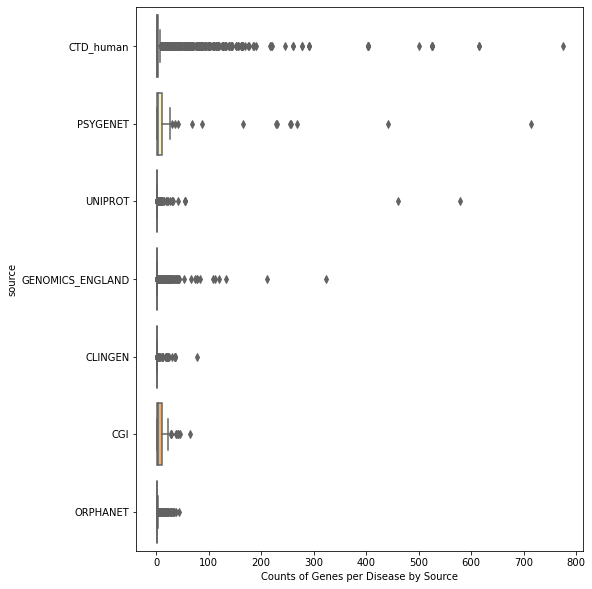

In [30]:
fig, ax = plt.subplots(figsize = (8,10))
sns.boxplot(y = 'source', x = 'Counts of Genes per Disease by Source',
                 data = logSumDisease, palette="Set3", orient = 'h')

## Boxplot of Log of Counts of Genes per Disease for each Source:

<AxesSubplot:xlabel='Log of Counts of Genes per Disease by Source', ylabel='source'>

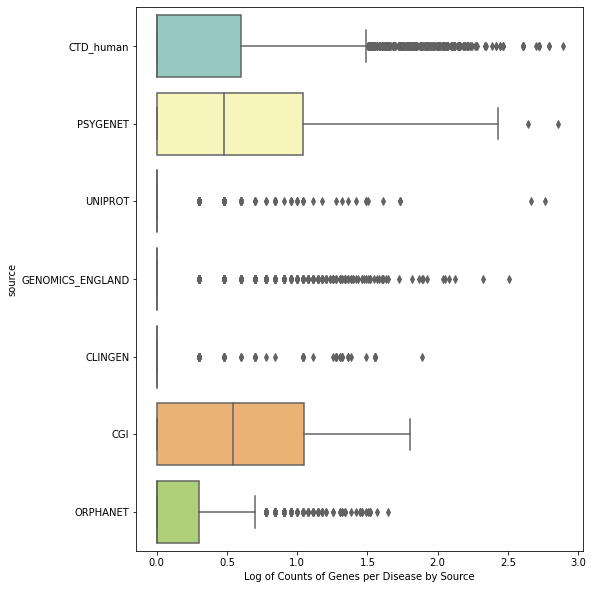

In [31]:
fig, ax = plt.subplots(figsize = (8,10))
sns.boxplot(y = 'source', x = 'Log of Counts of Genes per Disease by Source',
                 data = logSumDisease, palette="Set3", orient = 'h')

In [34]:
logSumDisease2

,diseaseId,Counts of Diseases
0,C0006142,1158
1,C0036341,887
2,C0023893,774
3,C0009402,755
4,C0376358,628
...,...,...
11176,C0751000,1
11177,C1970840,1
11178,C0751001,1
11179,C0153619,1


In [32]:
# Dataset with Fraction of Genes for a Disease per Source:
logSumDisease2 = threeColsep.groupby(by = ['diseaseId']).size().sort_values(ascending=False).reset_index(name = 'Counts of Diseases')
result = logSumDisease.merge(logSumDisease2)
result['Ratio'] = result['Counts of Genes per Disease by Source']/result['Counts of Diseases']
result

,diseaseId,source,Counts of Genes per Disease by Source,Log of Counts of Genes per Disease by Source,Counts of Diseases,Ratio
0,C0023893,CTD_human,774,2.888741,774,1.000000
1,C0036341,PSYGENET,713,2.853090,887,0.803833
2,C0036341,CTD_human,170,2.230449,887,0.191657
3,C0036341,GENOMICS_ENGLAND,3,0.477121,887,0.003382
4,C0036341,UNIPROT,1,0.000000,887,0.001127
...,...,...,...,...,...,...
22240,C1844830,GENOMICS_ENGLAND,1,0.000000,3,0.333333
22241,C1844830,UNIPROT,1,0.000000,3,0.333333
22242,C1844836,ORPHANET,1,0.000000,1,1.000000
22243,C1844853,GENOMICS_ENGLAND,1,0.000000,2,0.500000


## Boxplot of Fraction of Genes for a Disease per Source:

<AxesSubplot:xlabel='Ratio', ylabel='source'>

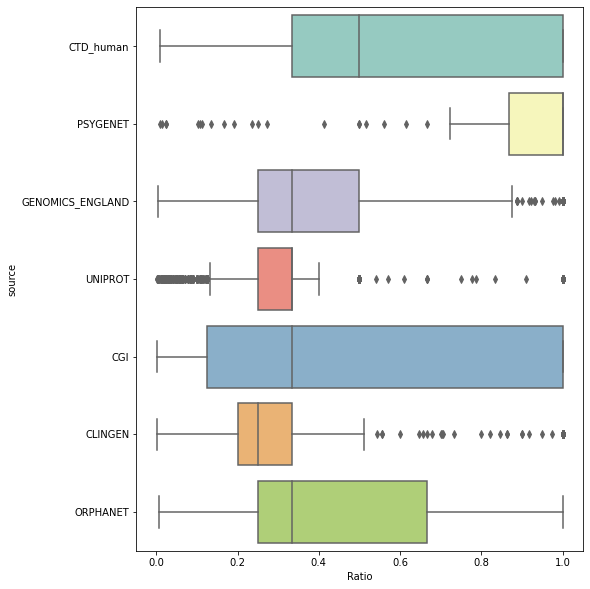

In [33]:
fig, ax = plt.subplots(figsize = (8,10))
sns.boxplot(y = 'source', x = 'Ratio',
                 data = result, palette="Set3", orient = 'h')
#The genes for each disease divided by the total number of genes for each association type. CTD_human has the largest median/fraction. CGI envompasses a large portion of the data

## Gene Comparison and Exploration:

In [8]:
# Creating Gene Sets for Each Source Based on Disease:
a = threeColsep.groupby(by = ['diseaseId', 'source'])['geneId'].apply(lambda x: set(x))
a = a.reset_index()
a

,diseaseId,source,geneId
0,C0000737,CTD_human,{3440}
1,C0000744,CTD_human,{4547}
2,C0000744,GENOMICS_ENGLAND,{4547}
3,C0000744,ORPHANET,{4547}
4,C0000744,UNIPROT,{4547}
...,...,...,...
22240,C4755278,ORPHANET,{22868}
22241,C4755299,ORPHANET,{4508}
22242,C4755302,ORPHANET,{1828}
22243,C4755309,ORPHANET,{1828}


In [10]:
# Creating Sets of Sources Based on Disease
a2 = a.groupby(by = ['diseaseId'])['source'].apply(lambda x: set(x))
a2 = a2.to_frame().reset_index()
a2

,diseaseId,source
0,C0000737,{CTD_human}
1,C0000744,"{CTD_human, UNIPROT, ORPHANET, GENOMICS_ENGLAND}"
2,C0000768,{CTD_human}
3,C0000771,{CTD_human}
4,C0000772,"{CTD_human, GENOMICS_ENGLAND}"
...,...,...
11176,C4755278,{ORPHANET}
11177,C4755299,{ORPHANET}
11178,C4755302,{ORPHANET}
11179,C4755309,{ORPHANET}


In [37]:
# Creating the Different Possible Combinations of Sources for Each Disease:
from itertools import product
a2['permutations'] = a2['source'].apply(lambda r: list(product(r,repeat = 2)))

In [38]:
# Removing the Diseases that Only Hold One Source:
a3 = a2[a2['permutations'].map(lambda d: len(d)) > 0]
a3

,diseaseId,source,permutations
0,C0000737,{CTD_human},"[(CTD_human, CTD_human)]"
1,C0000744,"{GENOMICS_ENGLAND, CTD_human, ORPHANET, UNIPROT}","[(GENOMICS_ENGLAND, GENOMICS_ENGLAND), (GENOMI..."
2,C0000768,{CTD_human},"[(CTD_human, CTD_human)]"
3,C0000771,{CTD_human},"[(CTD_human, CTD_human)]"
4,C0000772,"{GENOMICS_ENGLAND, CTD_human}","[(GENOMICS_ENGLAND, GENOMICS_ENGLAND), (GENOMI..."
...,...,...,...
11176,C4755278,{ORPHANET},"[(ORPHANET, ORPHANET)]"
11177,C4755299,{ORPHANET},"[(ORPHANET, ORPHANET)]"
11178,C4755302,{ORPHANET},"[(ORPHANET, ORPHANET)]"
11179,C4755309,{ORPHANET},"[(ORPHANET, ORPHANET)]"


In [39]:
# Making a Separate Row for Each Combination:
resultGE = pd.DataFrame([(c, tup.diseaseId) for tup in a3.itertuples() for c in tup.permutations])
resultGE = resultGE.rename(columns={0: 'Combos', 1: 'diseaseId'})

In [40]:
# Separating the Created Combinations into 2 Columns:
resultGE[['source1','source2']] = pd.DataFrame(resultGE.Combos.tolist(), index= resultGE.index)

In [41]:
resultGE['geneId1'] = np.nan
resultGE['geneId2'] = np.nan

In [42]:
arowList = []
arow2List = []
for index, row in resultGE.iterrows():
    midrow = a.loc[(a['diseaseId'] == row['diseaseId']) & (a['source'] == row['source1'])]
    arowList.append(midrow.iloc[0]['geneId'])
    
    midrow2 = a.loc[(a['diseaseId'] == row['diseaseId']) & (a['source'] == row['source2'])]
    arow2List.append(midrow2.iloc[0]['geneId'])

In [43]:
resultGE['geneId1'] = arowList
resultGE['geneId2'] = arow2List
resultGE = resultGE.drop(columns = ['Combos'])
resultGE['jaccardIndex'] = np.nan

In [44]:
# Jaccard Similarity Coefficient/Jaccard Index Function:
def jaccard(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union

In [45]:
def f(x):
    return jaccard(x['geneId1'], x['geneId2']) 

In [46]:
resultGE['jaccardIndex'] = resultGE.apply(f, axis = 1)
resultGE

,diseaseId,source1,source2,geneId1,geneId2,jaccardIndex
0,C0000737,CTD_human,CTD_human,{3440},{3440},1.0
1,C0000744,GENOMICS_ENGLAND,GENOMICS_ENGLAND,{4547},{4547},1.0
2,C0000744,GENOMICS_ENGLAND,CTD_human,{4547},{4547},1.0
3,C0000744,GENOMICS_ENGLAND,ORPHANET,{4547},{4547},1.0
4,C0000744,GENOMICS_ENGLAND,UNIPROT,{4547},{4547},1.0
...,...,...,...,...,...,...
58324,C4755278,ORPHANET,ORPHANET,{22868},{22868},1.0
58325,C4755299,ORPHANET,ORPHANET,{4508},{4508},1.0
58326,C4755302,ORPHANET,ORPHANET,{1828},{1828},1.0
58327,C4755309,ORPHANET,ORPHANET,{1828},{1828},1.0


## Boxplots for Gene Exploration:

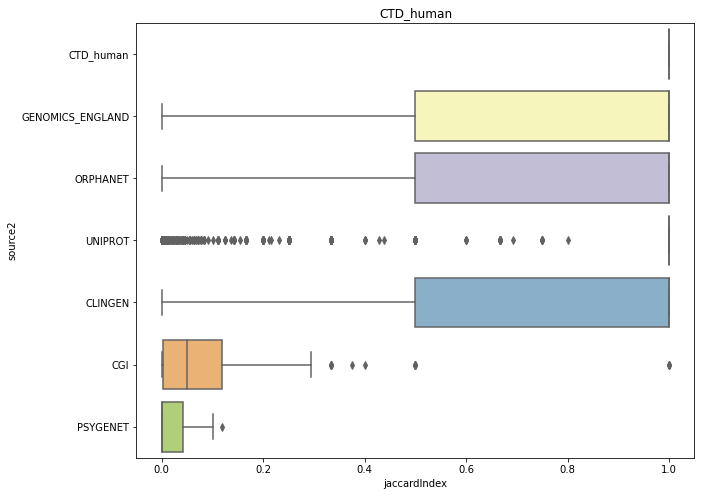

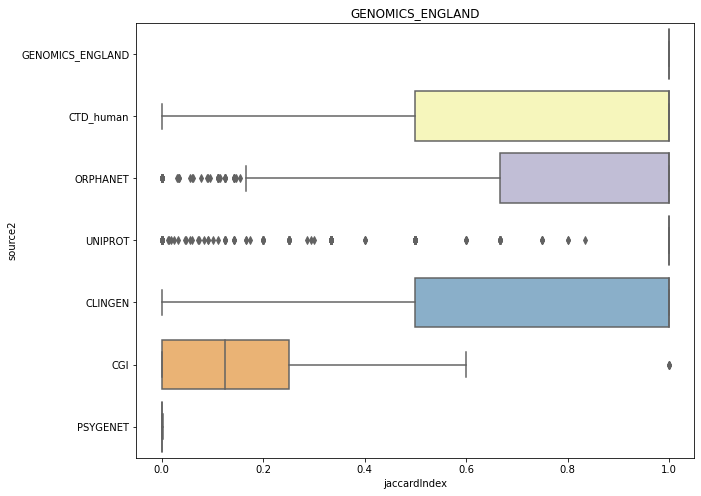

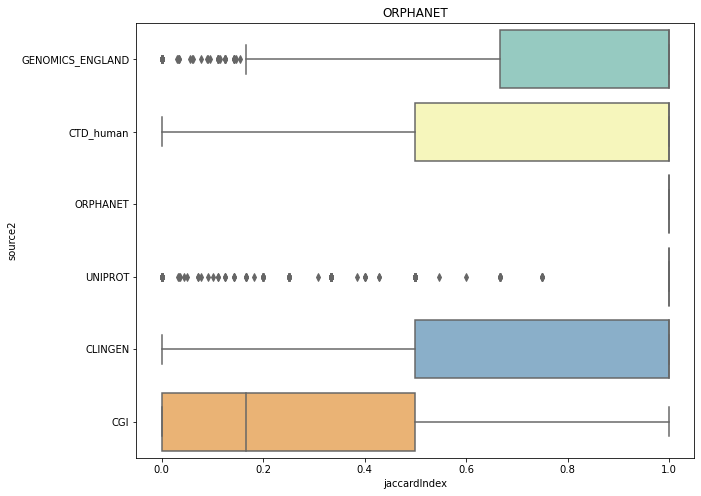

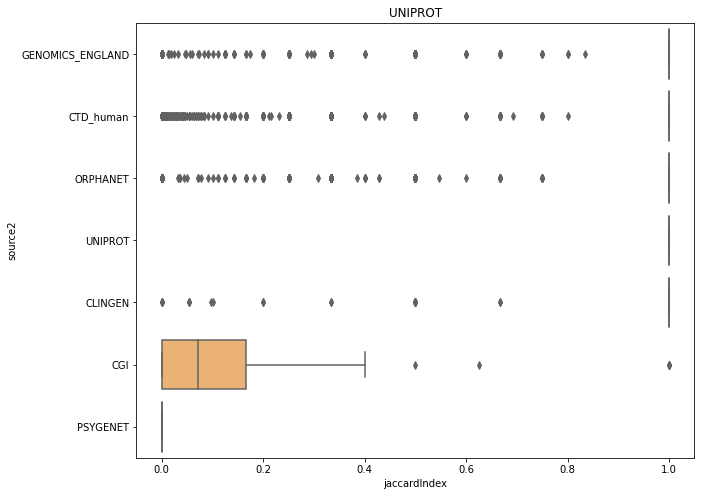

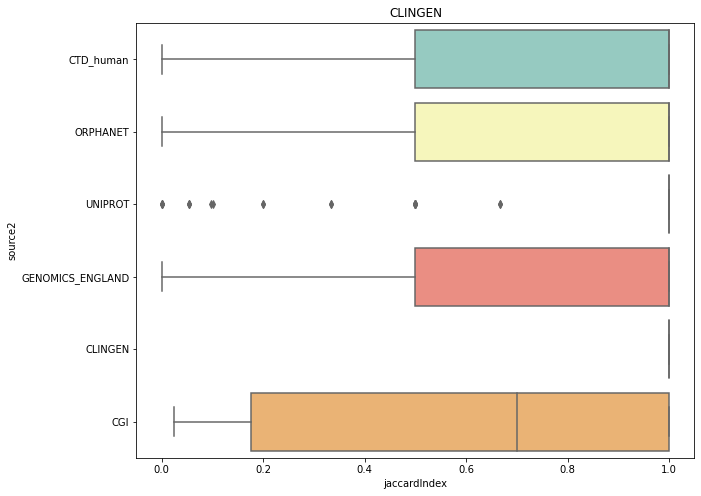

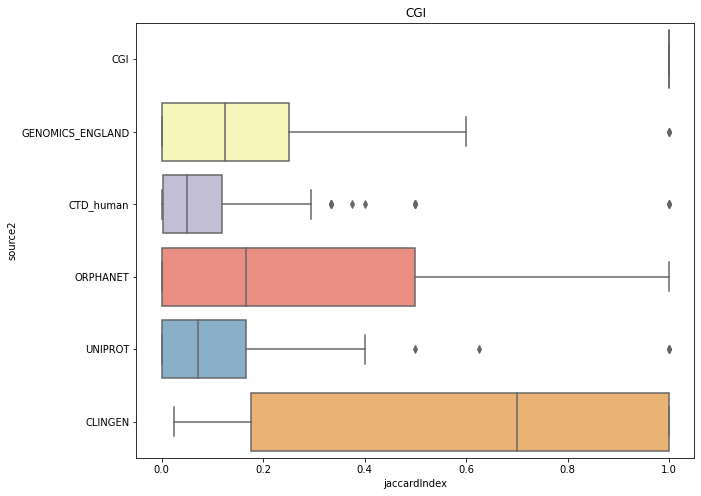

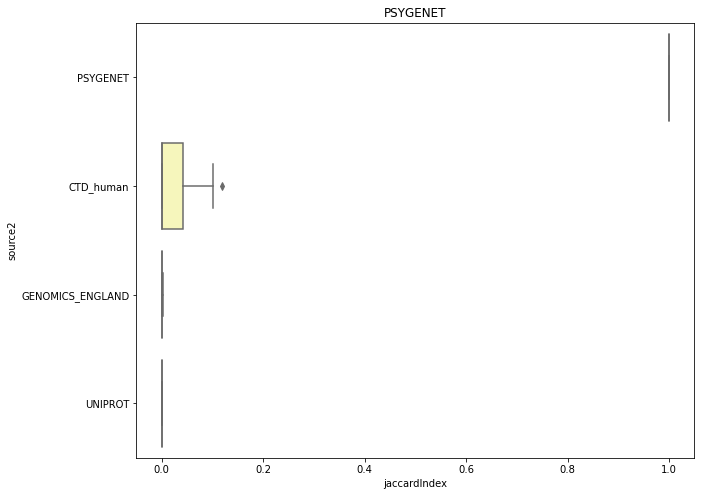

In [47]:
for i, source in enumerate(resultGE.source1.unique(), 1): #Iterating through each unique Source
    data = resultGE[resultGE.source1 == source] #Filtering by Source
    fig, ax = plt.subplots(figsize = (10,8))
    sns.boxplot(x = 'jaccardIndex', y = 'source2',
                 data = data, palette="Set3", orient = 'h')
    plt.title(source)

In [48]:
# Reorganizing the Dataset to Obtain the Median Values for Each Source Combination:
# This new dataset will have one row for each source combination, a set of the jaccard Indices for that source combination, and a median of the values for each of those sets. 
# Those median values are what will be placed in the heatmap!
resultGE2 = resultGE.drop(columns = ['diseaseId', 'geneId1', 'geneId2'])
resultGE2 = resultGE2.groupby(by = ['source1', 'source2'])['jaccardIndex'].apply(lambda x: list(x))
resultGE2 = resultGE2.reset_index()

In [49]:
jaccardsets = resultGE2['jaccardIndex']
medians = []
for set in jaccardsets:
    medians.append(statistics.median(set))
resultGE2['Median'] = medians
resultGE2

,source1,source2,jaccardIndex,Median
0,CGI,CGI,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.000000
1,CGI,CLINGEN,"[0.023809523809523808, 0.1, 1.0, 0.4, 1.0, 1.0]",0.700000
2,CGI,CTD_human,"[0.4, 0.0, 0.05, 0.05, 0.02631578947368421, 0....",0.048810
3,CGI,GENOMICS_ENGLAND,"[0.3333333333333333, 0.17391304347826086, 0.0,...",0.125000
4,CGI,ORPHANET,"[0.5, 0.043478260869565216, 1.0, 0.08695652173...",0.166667
5,CGI,UNIPROT,"[0.0, 0.058823529411764705, 0.0625, 0.0, 0.021...",0.071429
6,CLINGEN,CGI,"[0.023809523809523808, 0.1, 1.0, 0.4, 1.0, 1.0]",0.700000
7,CLINGEN,CLINGEN,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.000000
8,CLINGEN,CTD_human,"[1.0, 1.0, 1.0, 0.0, 0.4, 0.6666666666666666, ...",1.000000
9,CLINGEN,GENOMICS_ENGLAND,"[1.0, 1.0, 1.0, 0.10526315789473684, 0.6666666...",1.000000


## The Heatmap:
### Heatmap with Curated Dataset Median:

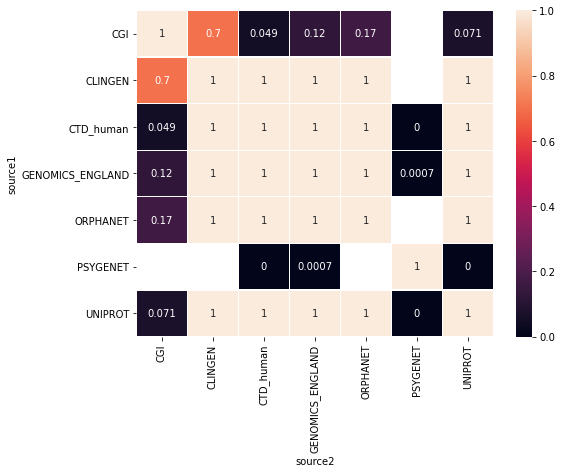

In [50]:
resultGE3 = resultGE2.pivot("source1", "source2", "Median")
fig, ax = plt.subplots(figsize=(8,6))   
ax = sns.heatmap(resultGE3, annot = True, linewidths = .25)

In [51]:
meansets = resultGE2['jaccardIndex']
means = []
for set in meansets:
    means.append(statistics.mean(set))
resultGE2['Mean'] = means
resultGE2

,source1,source2,jaccardIndex,Median,Mean
0,CGI,CGI,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.000000,1.000000
1,CGI,CLINGEN,"[0.023809523809523808, 0.1, 1.0, 0.4, 1.0, 1.0]",0.700000,0.587302
2,CGI,CTD_human,"[0.4, 0.0, 0.05, 0.05, 0.02631578947368421, 0....",0.048810,0.123378
3,CGI,GENOMICS_ENGLAND,"[0.3333333333333333, 0.17391304347826086, 0.0,...",0.125000,0.205939
4,CGI,ORPHANET,"[0.5, 0.043478260869565216, 1.0, 0.08695652173...",0.166667,0.307413
5,CGI,UNIPROT,"[0.0, 0.058823529411764705, 0.0625, 0.0, 0.021...",0.071429,0.155051
6,CLINGEN,CGI,"[0.023809523809523808, 0.1, 1.0, 0.4, 1.0, 1.0]",0.700000,0.587302
7,CLINGEN,CLINGEN,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.000000,1.000000
8,CLINGEN,CTD_human,"[1.0, 1.0, 1.0, 0.0, 0.4, 0.6666666666666666, ...",1.000000,0.738413
9,CLINGEN,GENOMICS_ENGLAND,"[1.0, 1.0, 1.0, 0.10526315789473684, 0.6666666...",1.000000,0.802304


## The Heatmap #2:
### Heatmap with Curated Dataset Mean:

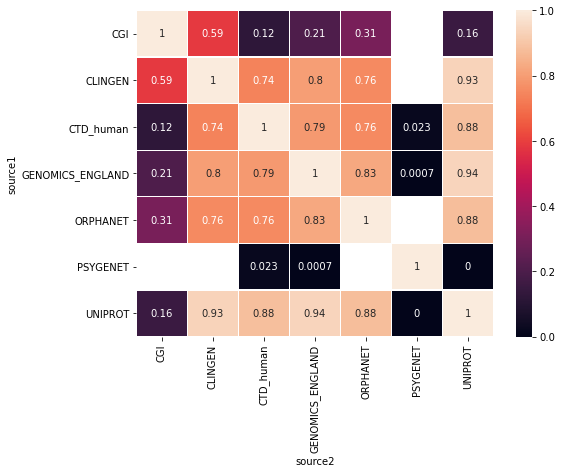

In [52]:
resultGE4 = resultGE2.pivot("source1", "source2", "Mean")
fig, ax = plt.subplots(figsize=(8,6))   
ax = sns.heatmap(resultGE4, annot = True, linewidths = .25)

## Re-doing the Process with Permutations instead of Permutations with Replacement:

In [11]:
# Creating the Different Possible Combinations of Sources for Each Disease:
from itertools import permutations
a2['permutations'] = a2['source'].apply(lambda r: list(permutations(r, 2)))

In [12]:
# Removing the Diseases that Only Hold One Source:
a3 = a2[a2['permutations'].map(lambda d: len(d)) > 0]
a3

,diseaseId,source,permutations
1,C0000744,"{CTD_human, GENOMICS_ENGLAND, ORPHANET, UNIPROT}","[(CTD_human, GENOMICS_ENGLAND), (CTD_human, OR..."
4,C0000772,"{CTD_human, GENOMICS_ENGLAND}","[(CTD_human, GENOMICS_ENGLAND), (GENOMICS_ENGL..."
10,C0001080,"{CTD_human, GENOMICS_ENGLAND, CLINGEN, ORPHANE...","[(CTD_human, GENOMICS_ENGLAND), (CTD_human, CL..."
12,C0001125,"{CTD_human, GENOMICS_ENGLAND}","[(CTD_human, GENOMICS_ENGLAND), (GENOMICS_ENGL..."
13,C0001126,"{CTD_human, GENOMICS_ENGLAND}","[(CTD_human, GENOMICS_ENGLAND), (GENOMICS_ENGL..."
...,...,...,...
11128,C4749003,"{GENOMICS_ENGLAND, UNIPROT}","[(GENOMICS_ENGLAND, UNIPROT), (UNIPROT, GENOMI..."
11129,C4749014,"{GENOMICS_ENGLAND, UNIPROT}","[(GENOMICS_ENGLAND, UNIPROT), (UNIPROT, GENOMI..."
11131,C4749023,"{GENOMICS_ENGLAND, UNIPROT}","[(GENOMICS_ENGLAND, UNIPROT), (UNIPROT, GENOMI..."
11132,C4749028,"{GENOMICS_ENGLAND, UNIPROT}","[(GENOMICS_ENGLAND, UNIPROT), (UNIPROT, GENOMI..."


In [13]:
# Making a Separate Row for Each Combination:
resultGE = pd.DataFrame([(c, tup.diseaseId) for tup in a3.itertuples() for c in tup.permutations])
resultGE = resultGE.rename(columns={0: 'Combos', 1: 'diseaseId'})

In [14]:
# Separating the Created Combinations into 2 Columns:
resultGE[['source1','source2']] = pd.DataFrame(resultGE.Combos.tolist(), index= resultGE.index)

In [15]:
resultGE['geneId1'] = np.nan
resultGE['geneId2'] = np.nan

In [16]:
arowList = []
arow2List = []
for index, row in resultGE.iterrows():
    midrow = a.loc[(a['diseaseId'] == row['diseaseId']) & (a['source'] == row['source1'])]
    arowList.append(midrow.iloc[0]['geneId'])
    
    midrow2 = a.loc[(a['diseaseId'] == row['diseaseId']) & (a['source'] == row['source2'])]
    arow2List.append(midrow2.iloc[0]['geneId'])

In [17]:
resultGE['geneId1'] = arowList
resultGE['geneId2'] = arow2List
resultGE = resultGE.drop(columns = ['Combos'])
resultGE['jaccardIndex'] = np.nan

In [18]:
# Jaccard Similarity Coefficient/Jaccard Index Function:
def jaccard(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union

In [19]:
def f(x):
    return jaccard(x['geneId1'], x['geneId2']) 

In [20]:
resultGE.head(50)

,diseaseId,source1,source2,geneId1,geneId2,jaccardIndex
0,C0000744,CTD_human,GENOMICS_ENGLAND,{4547},{4547},NaN
1,C0000744,CTD_human,ORPHANET,{4547},{4547},NaN
2,C0000744,CTD_human,UNIPROT,{4547},{4547},NaN
3,C0000744,GENOMICS_ENGLAND,CTD_human,{4547},{4547},NaN
4,C0000744,GENOMICS_ENGLAND,ORPHANET,{4547},{4547},NaN
5,C0000744,GENOMICS_ENGLAND,UNIPROT,{4547},{4547},NaN
6,C0000744,ORPHANET,CTD_human,{4547},{4547},NaN
7,C0000744,ORPHANET,GENOMICS_ENGLAND,{4547},{4547},NaN
8,C0000744,ORPHANET,UNIPROT,{4547},{4547},NaN
9,C0000744,UNIPROT,CTD_human,{4547},{4547},NaN


In [21]:
resultGE['jaccardIndex'] = resultGE.apply(f, axis = 1)
resultGE

,diseaseId,source1,source2,geneId1,geneId2,jaccardIndex
0,C0000744,CTD_human,GENOMICS_ENGLAND,{4547},{4547},1.0
1,C0000744,CTD_human,ORPHANET,{4547},{4547},1.0
2,C0000744,CTD_human,UNIPROT,{4547},{4547},1.0
3,C0000744,GENOMICS_ENGLAND,CTD_human,{4547},{4547},1.0
4,C0000744,GENOMICS_ENGLAND,ORPHANET,{4547},{4547},1.0
...,...,...,...,...,...,...
36079,C4749023,UNIPROT,GENOMICS_ENGLAND,{221692},{221692},1.0
36080,C4749028,GENOMICS_ENGLAND,UNIPROT,{1770},{1770},1.0
36081,C4749028,UNIPROT,GENOMICS_ENGLAND,{1770},{1770},1.0
36082,C4751204,GENOMICS_ENGLAND,ORPHANET,{1581},{1581},1.0


## Boxplots for Gene Exploration:

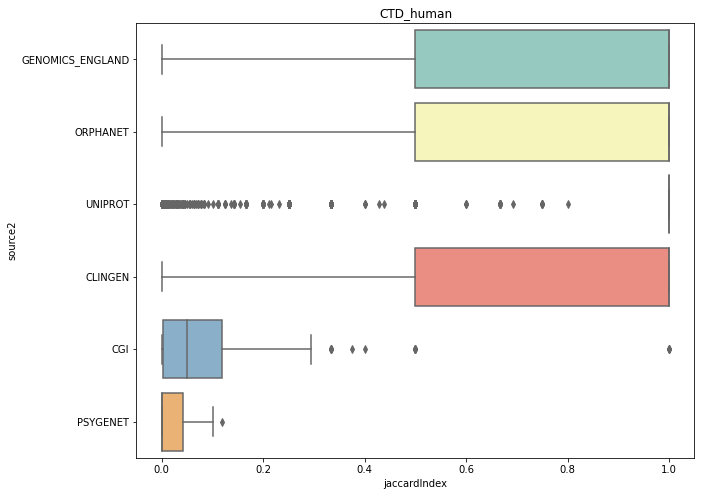

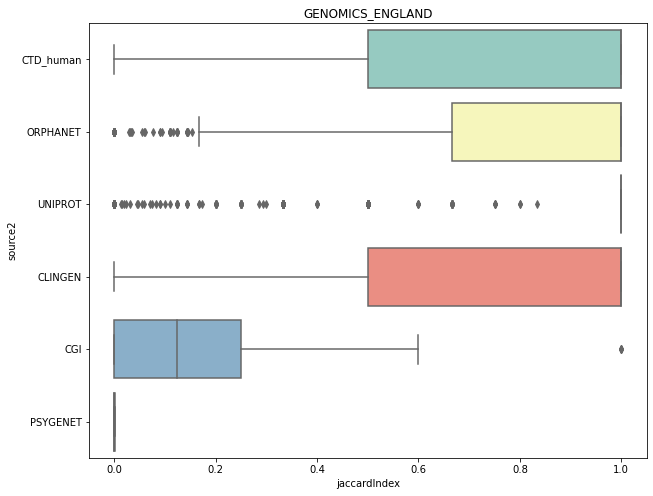

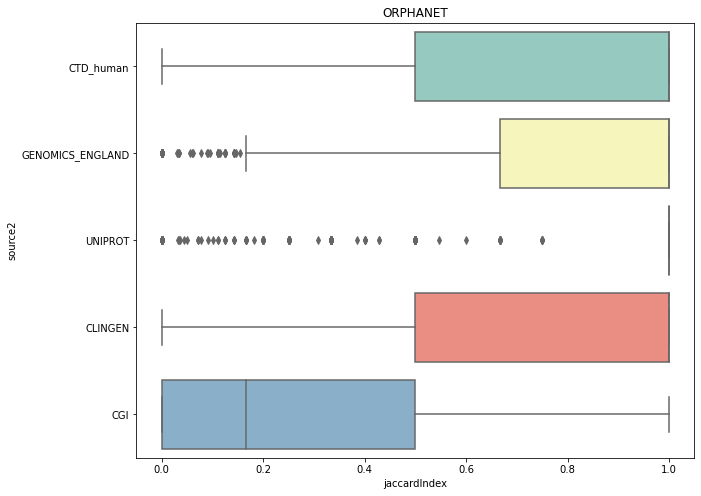

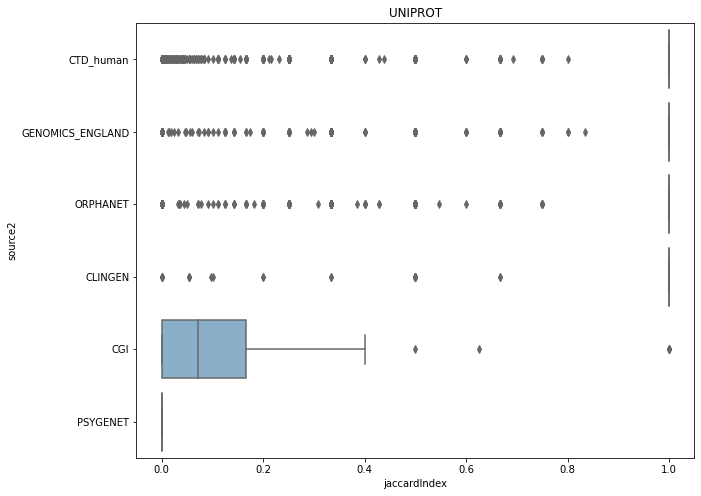

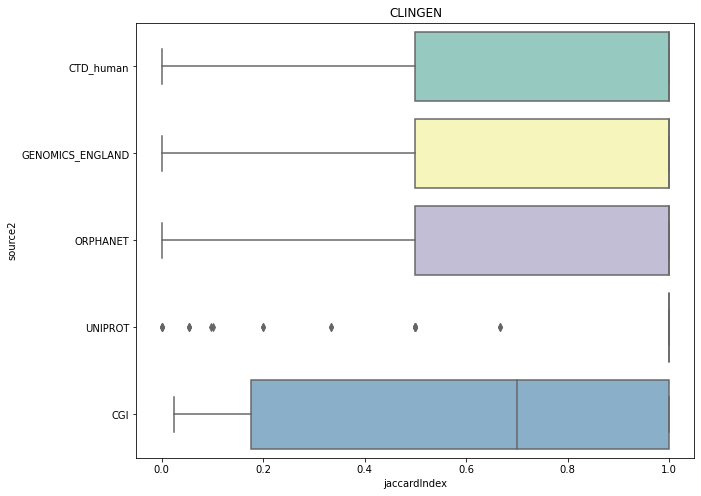

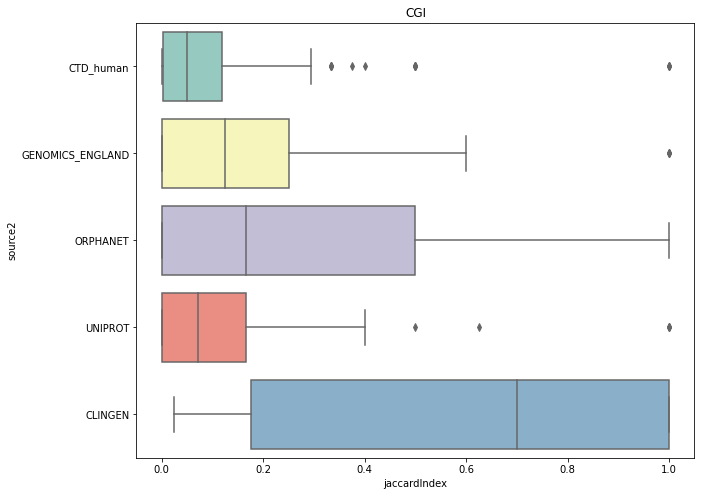

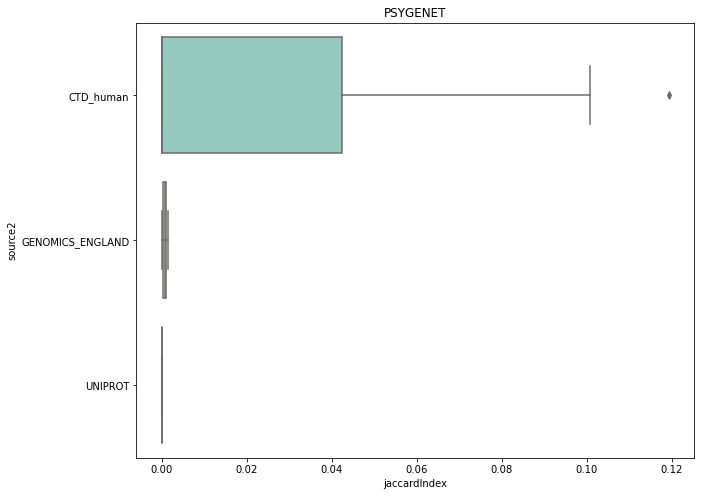

In [22]:
for i, source in enumerate(resultGE.source1.unique(), 1): #Iterating through each unique Source
    data = resultGE[resultGE.source1 == source] #Filtering by Source
    fig, ax = plt.subplots(figsize = (10,8))
    sns.boxplot(x = 'jaccardIndex', y = 'source2',
                 data = data, palette="Set3", orient = 'h')
    plt.title(source)

In [23]:
# Reorganizing the Dataset to Obtain the Median Values for Each Source Combination:
# This new dataset will have one row for each source combination, a set of the jaccard Indices for that source combination, and a median of the values for each of those sets. 
# Those median values are what will be placed in the heatmap!
resultGE2 = resultGE.drop(columns = ['diseaseId', 'geneId1', 'geneId2'])
resultGE2 = resultGE2.groupby(by = ['source1', 'source2'])['jaccardIndex'].apply(lambda x: list(x))
resultGE2 = resultGE2.reset_index()

In [24]:
jaccardsets = resultGE2['jaccardIndex']
medians = []
for set in jaccardsets:
    medians.append(statistics.median(set))
resultGE2['Median'] = medians
resultGE2

,source1,source2,jaccardIndex,Median
0,CGI,CLINGEN,"[0.023809523809523808, 0.1, 1.0, 0.4, 1.0, 1.0]",0.700000
1,CGI,CTD_human,"[0.4, 0.0, 0.05, 0.05, 0.02631578947368421, 0....",0.048810
2,CGI,GENOMICS_ENGLAND,"[0.3333333333333333, 0.17391304347826086, 0.0,...",0.125000
3,CGI,ORPHANET,"[0.5, 0.043478260869565216, 1.0, 0.08695652173...",0.166667
4,CGI,UNIPROT,"[0.0, 0.058823529411764705, 0.0625, 0.0, 0.021...",0.071429
5,CLINGEN,CGI,"[0.023809523809523808, 0.1, 1.0, 0.4, 1.0, 1.0]",0.700000
6,CLINGEN,CTD_human,"[1.0, 1.0, 1.0, 0.0, 0.4, 0.6666666666666666, ...",1.000000
7,CLINGEN,GENOMICS_ENGLAND,"[1.0, 1.0, 1.0, 0.10526315789473684, 0.6666666...",1.000000
8,CLINGEN,ORPHANET,"[1.0, 0.6666666666666666, 0.6666666666666666, ...",1.000000
9,CLINGEN,UNIPROT,"[1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, ...",1.000000


## The Heatmap:
### Heatmap with Curated Dataset Median:

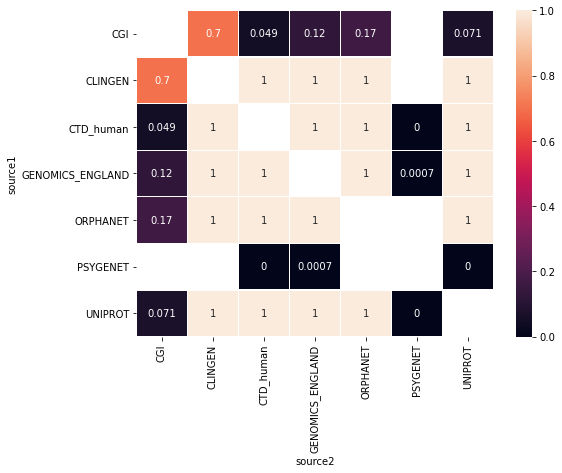

In [25]:
resultGE3 = resultGE2.pivot("source1", "source2", "Median")
fig, ax = plt.subplots(figsize=(8,6))   
ax = sns.heatmap(resultGE3, annot = True, linewidths = .25)

In [26]:
meansets = resultGE2['jaccardIndex']
means = []
for set in meansets:
    means.append(statistics.mean(set))
resultGE2['Mean'] = means
resultGE2

,source1,source2,jaccardIndex,Median,Mean
0,CGI,CLINGEN,"[0.023809523809523808, 0.1, 1.0, 0.4, 1.0, 1.0]",0.700000,0.587302
1,CGI,CTD_human,"[0.4, 0.0, 0.05, 0.05, 0.02631578947368421, 0....",0.048810,0.123378
2,CGI,GENOMICS_ENGLAND,"[0.3333333333333333, 0.17391304347826086, 0.0,...",0.125000,0.205939
3,CGI,ORPHANET,"[0.5, 0.043478260869565216, 1.0, 0.08695652173...",0.166667,0.307413
4,CGI,UNIPROT,"[0.0, 0.058823529411764705, 0.0625, 0.0, 0.021...",0.071429,0.155051
5,CLINGEN,CGI,"[0.023809523809523808, 0.1, 1.0, 0.4, 1.0, 1.0]",0.700000,0.587302
6,CLINGEN,CTD_human,"[1.0, 1.0, 1.0, 0.0, 0.4, 0.6666666666666666, ...",1.000000,0.738413
7,CLINGEN,GENOMICS_ENGLAND,"[1.0, 1.0, 1.0, 0.10526315789473684, 0.6666666...",1.000000,0.802304
8,CLINGEN,ORPHANET,"[1.0, 0.6666666666666666, 0.6666666666666666, ...",1.000000,0.757499
9,CLINGEN,UNIPROT,"[1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, ...",1.000000,0.934761


## The Heatmap #2:
### Heatmap with Curated Dataset Mean:

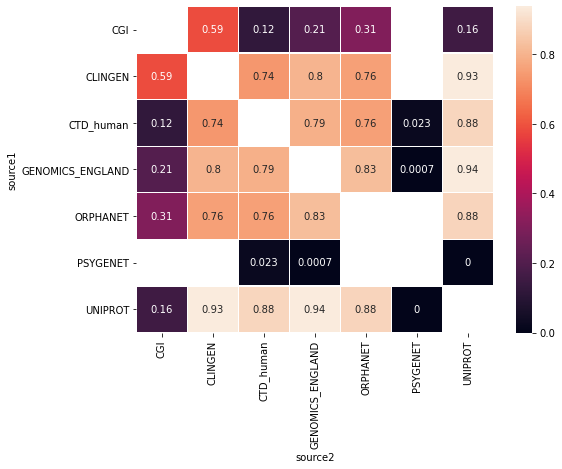

In [27]:
resultGE4 = resultGE2.pivot("source1", "source2", "Mean")
fig, ax = plt.subplots(figsize=(8,6))   
ax = sns.heatmap(resultGE4, annot = True, linewidths = .25)

### Combined Dataset:

In [29]:
diseaseinfo = pd.read_csv('diseaseAttributes.tsv', sep = "\t")
geneinfo = pd.read_csv('geneAttributes.tsv', sep = "\t")
geneinfo = geneinfo.drop(columns = ['pLI', 'DSI', 'DPI'])
result1 = threeColsep.merge(diseaseinfo)
result2 = result1.merge(geneinfo)
dfOG = pd.read_csv('geneDiseaseNetwork.tsv', sep = "\t")
combined = result2.merge(dfOG)
combined

/mnt/home/f0102402/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,source,geneId,geneSymbol,diseaseId,diseaseName,diseaseNID,type,geneNID,geneName,geneDescription,NID,association,associationType,sentence,pmid,score,EL,EI,year
0,CTD_human,1,A1BG,C0019209,Hepatomegaly,1371,phenotype,1,A1BG,alpha-1-B glycoprotein,770711,NaN,Biomarker,Discriminating between adaptive and carcinogen...,28108177.0,0.30,NaN,1.0,2017.0
1,CTD_human,1,A1BG,C0036341,Schizophrenia,2733,disease,1,A1BG,alpha-1-B glycoprotein,1453814,NaN,Biomarker,Effects of olanzapine on serum protein phospho...,25821032.0,0.30,NaN,1.0,2015.0
2,CTD_human,196,AHR,C0019209,Hepatomegaly,1371,phenotype,144,AHR,aryl hydrocarbon receptor,770798,NaN,Biomarker,Aryl hydrocarbon receptor knockout rats are in...,26278112.0,0.30,NaN,1.0,2016.0
3,CTD_human,196,AHR,C0019209,Hepatomegaly,1371,phenotype,144,AHR,aryl hydrocarbon receptor,770799,NaN,Therapeutic,Aryl hydrocarbon receptor knockout rats are in...,26278112.0,0.30,NaN,1.0,2016.0
4,CTD_human,196,AHR,C0019209,Hepatomegaly,1371,phenotype,144,AHR,aryl hydrocarbon receptor,770800,NaN,Biomarker,Dioxin-induced increase in leukotriene B4 bios...,28487374.0,0.30,NaN,1.0,2017.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151272,ORPHANET,100996717,NOTCH2NLC,C1863843,Neuronal intranuclear inclusion disease,18944,disease,21542,NOTCH2NLC,notch 2 N-terminal like C,2910614,NaN,GermlineCausalMutation,"Therefore, we suggest defining a term NIID-rel...",31178126.0,0.53,NaN,1.0,2019.0
151273,GENOMICS_ENGLAND,101926885,OCA5,C3888401,"ALBINISM, OCULOCUTANEOUS, TYPE V",24241,disease,21604,OCA5,oculocutaneous albinism 5 (autosomal recessive),3122966,NaN,Biomarker,Ophthalmo-genetic analysis of Pakistani patien...,28507374.0,0.30,NaN,1.0,2017.0
151274,GENOMICS_ENGLAND,106783499,OPA8,C4085249,OPTIC ATROPHY 8,27279,disease,25057,OPA8,optic atrophy 8 (autosomal dominant),3154549,NaN,Biomarker,NaN,NaN,0.30,NaN,NaN,NaN
151275,CTD_human,107305681,DHS6S1,C0730294,North Carolina macular dystrophy,11159,disease,25078,DHS6S1,"Macular dystrophy, North Carolina type",2411347,NaN,Biomarker,NaN,NaN,0.50,NaN,1.0,NaN


In [39]:
#combined = combined.drop(columns = ['type', 'association', 'sentence', 'pmid', 'score', 'EL', 'EI', 'year'])
combined = combined[['NID', 'diseaseNID', 'diseaseId', 'diseaseName', 'geneNID', 'geneId', 'geneName', 'associationType', 'source']]
combined

,NID,diseaseNID,diseaseId,diseaseName,geneNID,geneId,geneName,associationType,source
0,770711,1371,C0019209,Hepatomegaly,1,1,A1BG,Biomarker,CTD_human
1,1453814,2733,C0036341,Schizophrenia,1,1,A1BG,Biomarker,CTD_human
2,770798,1371,C0019209,Hepatomegaly,144,196,AHR,Biomarker,CTD_human
3,770799,1371,C0019209,Hepatomegaly,144,196,AHR,Therapeutic,CTD_human
4,770800,1371,C0019209,Hepatomegaly,144,196,AHR,Biomarker,CTD_human
...,...,...,...,...,...,...,...,...,...
151272,2910614,18944,C1863843,Neuronal intranuclear inclusion disease,21542,100996717,NOTCH2NLC,GermlineCausalMutation,ORPHANET
151273,3122966,24241,C3888401,"ALBINISM, OCULOCUTANEOUS, TYPE V",21604,101926885,OCA5,Biomarker,GENOMICS_ENGLAND
151274,3154549,27279,C4085249,OPTIC ATROPHY 8,25057,106783499,OPA8,Biomarker,GENOMICS_ENGLAND
151275,2411347,11159,C0730294,North Carolina macular dystrophy,25078,107305681,DHS6S1,Biomarker,CTD_human


## Determining the Number of Genes for Each Source:

In [67]:
unique = threeColsep.groupby(by = ['source']).count()
unique

,geneId,geneSymbol,diseaseId,diseaseName
source,,,,
CGI,1557,1557,1557,1557
CLINGEN,1260,1260,1260,1260
CTD_human,67471,67471,67471,67471
GENOMICS_ENGLAND,11215,11215,11215,11215
ORPHANET,6398,6398,6398,6398
PSYGENET,3296,3296,3296,3296
UNIPROT,5728,5728,5728,5728


## Separate Heatmap:

In [8]:
threeColsep

,source,geneId,geneSymbol,diseaseId,diseaseName
0,CTD_human,1,A1BG,C0019209,Hepatomegaly
1,CTD_human,1,A1BG,C0036341,Schizophrenia
2,CTD_human,2,A2M,C0002395,Alzheimer's Disease
3,CTD_human,2,A2M,C0007102,Malignant tumor of colon
4,CTD_human,2,A2M,C0009375,Colonic Neoplasms
...,...,...,...,...,...
96920,CTD_human,109580095,HBB-LCR,C0002875,Cooley's anemia
96921,CTD_human,109580095,HBB-LCR,C0005283,beta Thalassemia
96922,CTD_human,109580095,HBB-LCR,C0019025,Hemoglobin F Disease
96923,CTD_human,109580095,HBB-LCR,C0085578,Thalassemia Minor


In [12]:
diseaseinfo = pd.read_csv('diseaseAttributes.tsv', sep = "\t")
diseaseinfo = diseaseinfo.drop(columns = ['diseaseName', 'type'])
diseaseinfo

,diseaseNID,diseaseId
0,1,C0000727
1,2,C0000729
2,3,C0000731
3,4,C0000734
4,5,C0000735
...,...,...
30288,30289,C4755314
30289,30290,C4757950
30290,30291,C4757951
30291,30292,C4759295


In [13]:
geneinfo = pd.read_csv('geneAttributes.tsv', sep = "\t")
geneinfo = geneinfo.drop(columns = ['pLI', 'DSI', 'DPI', 'geneName', 'geneDescription'])
geneinfo

,geneNID,geneId
0,1,1
1,2,2
2,3,3
3,4,9
4,5,10
...,...,...
26132,26133,115482722
26133,26134,115482723
26134,26135,115561815
26135,26136,115804232


In [15]:
threeCol2 = threeColsep.drop(columns = ['geneSymbol', 'diseaseName'])
threeCol2

,source,geneId,diseaseId
0,CTD_human,1,C0019209
1,CTD_human,1,C0036341
2,CTD_human,2,C0002395
3,CTD_human,2,C0007102
4,CTD_human,2,C0009375
...,...,...,...
96920,CTD_human,109580095,C0002875
96921,CTD_human,109580095,C0005283
96922,CTD_human,109580095,C0019025
96923,CTD_human,109580095,C0085578


In [16]:
result1 = threeCol2.merge(diseaseinfo)
result1

,source,geneId,diseaseId,diseaseNID
0,CTD_human,1,C0019209,1371
1,CTD_human,196,C0019209,1371
2,CTD_human,213,C0019209,1371
3,CTD_human,219,C0019209,1371
4,CTD_human,815,C0019209,1371
...,...,...,...,...
96920,CTD_human,100996717,C1863843,18944
96921,GENOMICS_ENGLAND,101926885,C3888401,24241
96922,GENOMICS_ENGLAND,106783499,C4085249,27279
96923,ORPHANET,107305681,C0730294,11159


In [20]:
result2 = result1.merge(geneinfo)
result2 = result2.drop(columns = ['geneId', 'diseaseId'])
result2 = result2.rename(columns = {'source': 'propAssociationType/source'})
result2

,propAssociationType/source,diseaseNID,geneNID
0,CTD_human,1371,1
1,CTD_human,2733,1
2,CTD_human,1371,144
3,CTD_human,1796,144
4,CTD_human,5405,144
...,...,...,...
96920,CTD_human,18944,21542
96921,GENOMICS_ENGLAND,24241,21604
96922,GENOMICS_ENGLAND,27279,25057
96923,ORPHANET,11159,25078


In [19]:
relabeled = pd.read_csv('relabeledDataset.csv')
relabeled = relabeled.drop(columns = ['ogAssociationTypes'])
relabeled = relabeled.rename(columns={'propagatedAssociationType': 'propAssociationType/source'})
relabeled

,diseaseNID,geneNID,propAssociationType/source
0,1317,1088,AlteredExpression
1,1338,1088,AlteredExpression
2,1741,1088,AlteredExpression
3,2107,1088,PosttranslationalModification
4,2592,1088,AlteredExpression
...,...,...,...
1202259,29239,20075,Biomarker
1202260,29280,20163,Biomarker
1202261,29341,20169,Biomarker
1202262,29763,9527,Biomarker


In [21]:
sourceAndAssoc = relabeled.append(result2)
sourceAndAssoc

,diseaseNID,geneNID,propAssociationType/source
0,1317,1088,AlteredExpression
1,1338,1088,AlteredExpression
2,1741,1088,AlteredExpression
3,2107,1088,PosttranslationalModification
4,2592,1088,AlteredExpression
...,...,...,...
96920,18944,21542,CTD_human
96921,24241,21604,GENOMICS_ENGLAND
96922,27279,25057,GENOMICS_ENGLAND
96923,11159,25078,ORPHANET


In [23]:
# Creating Gene Sets for Each Association Type Based on Disease:
a = sourceAndAssoc.groupby(by = ['diseaseNID', 'propAssociationType/source'])['geneNID'].apply(lambda x: set(x))
a = a.reset_index()
a

,diseaseNID,propAssociationType/source,geneNID
0,1,Biomarker,"{1088, 3070}"
1,2,Biomarker,{10721}
2,3,Biomarker,"{522, 525, 7694, 5650, 5139, 11283, 12826, 156..."
3,3,GenomicAlterations,"{4711, 6417, 5458, 1813, 3065, 17182}"
4,4,Biomarker,"{8402, 2627}"
...,...,...,...
76445,30291,GenomicAlterations,{5241}
76446,30292,AlteredExpression,"{3833, 11963, 2493, 270}"
76447,30292,Biomarker,"{18471, 46, 19792, 632, 1115, 1436, 2111, 3551}"
76448,30292,GenomicAlterations,"{2403, 1738, 9805, 270, 6738, 3829, 4057}"


In [24]:
# Creating Sets of association Types Based on Disease
a2 = a.groupby(by = ['diseaseNID'])['propAssociationType/source'].apply(lambda x: set(x))
a2 = a2.to_frame().reset_index()
a2

,diseaseNID,propAssociationType/source
0,1,{Biomarker}
1,2,{Biomarker}
2,3,"{Biomarker, GenomicAlterations}"
3,4,{Biomarker}
4,5,"{Biomarker, AlteredExpression, GenomicAlterati..."
...,...,...
30165,30289,{GenomicAlterations}
30166,30290,"{ORPHANET, GenomicAlterations}"
30167,30291,{GenomicAlterations}
30168,30292,"{Biomarker, AlteredExpression, GenomicAlterati..."


In [25]:
# Creating the Different Possible Combinations of Association Types for Each Disease:
from itertools import product
a2['permutations'] = a2['propAssociationType/source'].apply(lambda r: list(product(r,repeat = 2)))

In [26]:
# Removing the Diseases that Only Hold One Association Type:
a3 = a2[a2['permutations'].map(lambda d: len(d)) > 0]
a3

,diseaseNID,propAssociationType/source,permutations
0,1,{Biomarker},"[(Biomarker, Biomarker)]"
1,2,{Biomarker},"[(Biomarker, Biomarker)]"
2,3,"{Biomarker, GenomicAlterations}","[(Biomarker, Biomarker), (Biomarker, GenomicAl..."
3,4,{Biomarker},"[(Biomarker, Biomarker)]"
4,5,"{Biomarker, AlteredExpression, GenomicAlterati...","[(Biomarker, Biomarker), (Biomarker, AlteredEx..."
...,...,...,...
30165,30289,{GenomicAlterations},"[(GenomicAlterations, GenomicAlterations)]"
30166,30290,"{ORPHANET, GenomicAlterations}","[(ORPHANET, ORPHANET), (ORPHANET, GenomicAlter..."
30167,30291,{GenomicAlterations},"[(GenomicAlterations, GenomicAlterations)]"
30168,30292,"{Biomarker, AlteredExpression, GenomicAlterati...","[(Biomarker, Biomarker), (Biomarker, AlteredEx..."


In [27]:
# Making a Separate Row for Each Combination:
resultGE = pd.DataFrame([(c, tup.diseaseNID) for tup in a3.itertuples() for c in tup.permutations])
resultGE = resultGE.rename(columns={0: 'Combos', 1: 'diseaseNID'})

In [28]:
# Separating the Created Combinations into 2 Columns:
resultGE[['assocSource1','assocSource2']] = pd.DataFrame(resultGE.Combos.tolist(), index= resultGE.index)

In [29]:
arowList = []
arow2List = []
for index, row in resultGE.iterrows():
    midrow = a.loc[(a['diseaseNID'] == row['diseaseNID']) & (a['propAssociationType/source'] == row['assocSource1'])]
    arowList.append(midrow.iloc[0]['geneNID'])
    
    midrow2 = a.loc[(a['diseaseNID'] == row['diseaseNID']) & (a['propAssociationType/source'] == row['assocSource2'])]
    arow2List.append(midrow2.iloc[0]['geneNID'])

In [30]:
resultGE['geneNID1'] = arowList
resultGE['geneNID2'] = arow2List
resultGE = resultGE.drop(columns = ['Combos'])
resultGE['jaccardIndex'] = np.nan

In [31]:
# Jaccard Similarity Coefficient/Jaccard Index Function:
def jaccard(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union

In [32]:
def f(x):
    return jaccard(x['geneNID1'], x['geneNID2']) 

In [33]:
resultGE['jaccardIndex'] = resultGE.apply(f, axis = 1)
resultGE

,diseaseNID,assocSource1,assocSource2,geneNID1,geneNID2,jaccardIndex
0,1,Biomarker,Biomarker,"{1088, 3070}","{1088, 3070}",1.0
1,2,Biomarker,Biomarker,{10721},{10721},1.0
2,3,Biomarker,Biomarker,"{522, 525, 7694, 5650, 5139, 11283, 12826, 156...","{522, 525, 7694, 5650, 5139, 11283, 12826, 156...",1.0
3,3,Biomarker,GenomicAlterations,"{522, 525, 7694, 5650, 5139, 11283, 12826, 156...","{4711, 6417, 5458, 1813, 3065, 17182}",0.0
4,3,GenomicAlterations,Biomarker,"{4711, 6417, 5458, 1813, 3065, 17182}","{522, 525, 7694, 5650, 5139, 11283, 12826, 156...",0.0
...,...,...,...,...,...,...
273657,30292,AlteredExpression,GenomicAlterations,"{3833, 11963, 2493, 270}","{2403, 1738, 9805, 270, 6738, 3829, 4057}",0.1
273658,30292,GenomicAlterations,Biomarker,"{2403, 1738, 9805, 270, 6738, 3829, 4057}","{18471, 46, 19792, 632, 1115, 1436, 2111, 3551}",0.0
273659,30292,GenomicAlterations,AlteredExpression,"{2403, 1738, 9805, 270, 6738, 3829, 4057}","{3833, 11963, 2493, 270}",0.1
273660,30292,GenomicAlterations,GenomicAlterations,"{2403, 1738, 9805, 270, 6738, 3829, 4057}","{2403, 1738, 9805, 270, 6738, 3829, 4057}",1.0


In [34]:
# Reorganizing the Dataset to Obtain the Median Values for Each Association Type Combination:
# This new dataset will have one row for each association type combination, a set of the jaccard Indices for that association type combination, and a median of the values for each of those sets. Those median values are what will be placed in the heatmap
resultGE2 = resultGE.drop(columns = ['diseaseNID', 'geneNID1', 'geneNID2'])
resultGE2 = resultGE2.groupby(by = ['assocSource1', 'assocSource2'])['jaccardIndex'].apply(lambda x: list(x))
resultGE2 = resultGE2.reset_index()

In [35]:
jaccardsets = resultGE2['jaccardIndex']
medians = []
for set in jaccardsets:
    medians.append(statistics.median(set))
resultGE2['Median'] = medians
resultGE2

,assocSource1,assocSource2,jaccardIndex,Median
0,AlteredExpression,AlteredExpression,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.000000
1,AlteredExpression,Biomarker,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000
2,AlteredExpression,CGI,"[0.0, 0.01834862385321101, 0.0, 0.008264462809...",0.007692
3,AlteredExpression,CLINGEN,"[0.1111111111111111, 0.16666666666666666, 0.04...",0.066667
4,AlteredExpression,CTD_human,"[0.0, 0.07692307692307693, 0.02877697841726619...",0.014286
...,...,...,...,...
133,UNIPROT,ORPHANET,"[1.0, 1.0, 1.0, 1.0, 0.0, 0.3333333333333333, ...",1.000000
134,UNIPROT,PSYGENET,[0.0],0.000000
135,UNIPROT,PosttranslationalModification,"[0.018518518518518517, 0.0, 0.0, 0.0, 0.1, 0.0...",0.000000
136,UNIPROT,Therapeutic,"[0.02857142857142857, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.000000


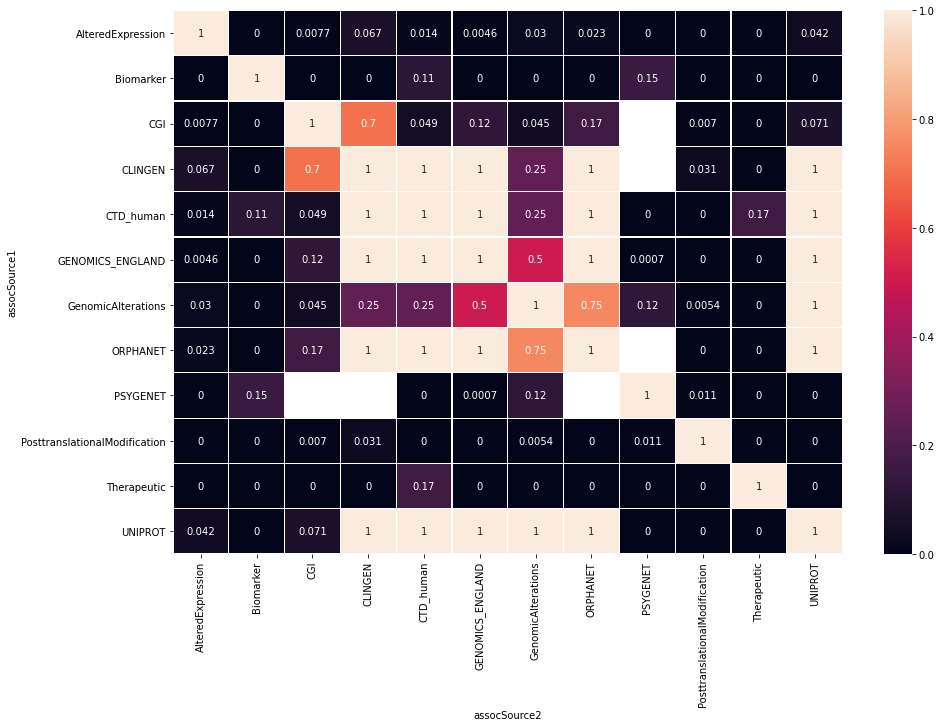

In [36]:
resultGE3 = resultGE2.pivot("assocSource1", "assocSource2", "Median")
resultGE3.index = pd.CategoricalIndex(resultGE3.index, categories= ['Biomarker', 'Therapeutic', 'AlteredExpression', 'GenomicAlterations', 'PosttranslationalModification', 'CTD_human', 'GENOMICS_ENGLAND', 'ORPHANET', 'UNIPROT', 'PSYGENET', 'CGI', 'CLINGEN'])
resultGE3.sort_index(level=0, inplace=True)
#fig, ax = plt.subplots(figsize=(15,10))   
#ax = sns.heatmap(resultGE3, annot = True, linewidths = .25)

In [55]:
resultGE3 = resultGE3[['Biomarker', 'Therapeutic', 'AlteredExpression', 'GenomicAlterations', 'PosttranslationalModification', 'CTD_human', 'GENOMICS_ENGLAND', 'ORPHANET', 'UNIPROT', 'PSYGENET', 'CGI', 'CLINGEN']]
resultGE3

assocSource2,Biomarker,Therapeutic,AlteredExpression,GenomicAlterations,PosttranslationalModification,CTD_human,GENOMICS_ENGLAND,ORPHANET,UNIPROT,PSYGENET,CGI,CLINGEN
assocSource1,,,,,,,,,,,,
Biomarker,1.000000,0.000000,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,0.153846,0.000000,0.000000
Therapeutic,0.000000,1.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AlteredExpression,0.000000,0.000000,1.000000,0.030303,0.000000,0.014286,0.004619,0.022727,0.041667,0.000000,0.007692,0.066667
GenomicAlterations,0.000000,0.000000,0.030303,1.000000,0.005435,0.250000,0.500000,0.750000,1.000000,0.121692,0.045455,0.250000
PosttranslationalModification,0.000000,0.000000,0.000000,0.005435,1.000000,0.000000,0.000000,0.000000,0.000000,0.010899,0.007042,0.031250
CTD_human,0.111111,0.166667,0.014286,0.250000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.048810,1.000000
GENOMICS_ENGLAND,0.000000,0.000000,0.004619,0.500000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000699,0.125000,1.000000
ORPHANET,0.000000,0.000000,0.022727,0.750000,0.000000,1.000000,1.000000,1.000000,1.000000,NaN,0.166667,1.000000
UNIPROT,0.000000,0.000000,0.041667,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.071429,1.000000


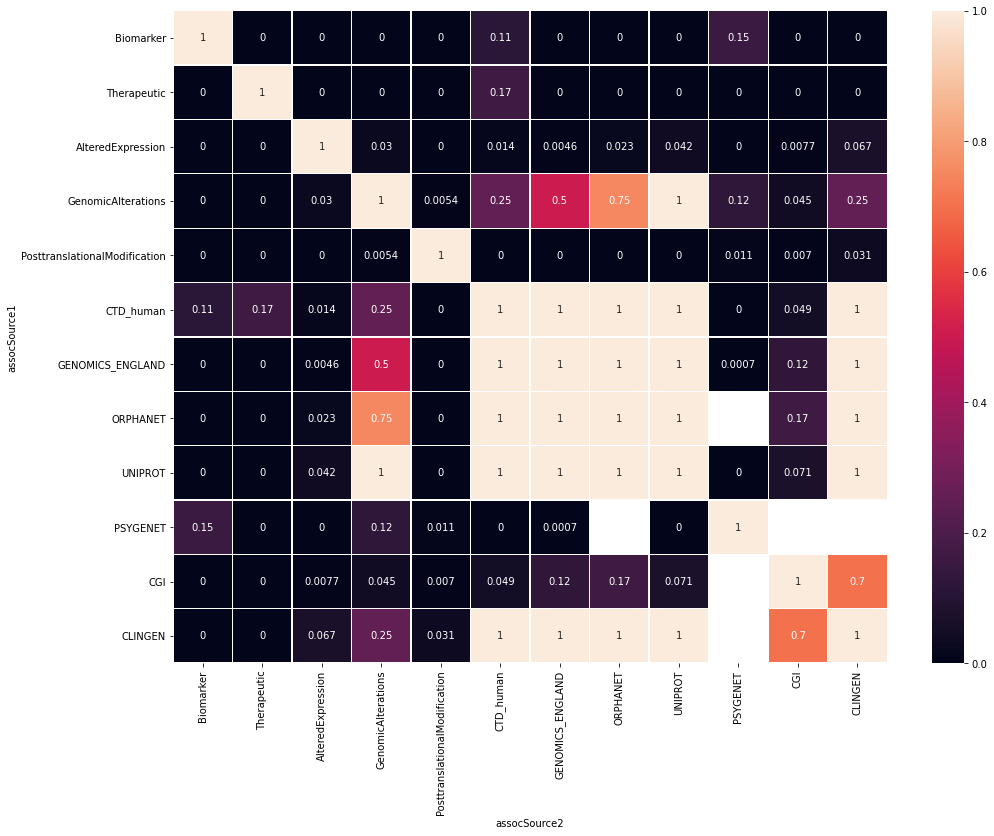

In [60]:
fig, ax = plt.subplots(figsize=(16,12))   
ax = sns.heatmap(resultGE3, annot = True, linewidths = .25)

## Next Steps:

In [10]:
diseasemappings = pd.read_csv('disease_mappings.tsv', sep = '\t')
diseasemappings

,diseaseId,name,vocabulary,code,vocabularyName
0,C0018923,Hemangiosarcoma,DO,0001816,angiosarcoma
1,C0854893,Angiosarcoma non-metastatic,DO,0001816,angiosarcoma
2,C0033999,Pterygium,DO,0002116,pterygium
3,C0025517,Metabolic Diseases,DO,0014667,disease of metabolism
4,C0155862,Streptococcal pneumonia,DO,0040084,Streptococcus pneumonia
...,...,...,...,...,...
242884,C0279628,Adenocarcinoma Of Esophagus,ORDO,99976,Adenocarcinoma of the esophagus
242885,C0279626,Squamous cell carcinoma of esophagus,ORDO,99977,Squamous cell carcinoma of the esophagus
242886,C0206702,Klatskin Tumor,ORDO,99978,Klatskin tumor
242887,C0007462,Causalgia,ORDO,99994,Complex regional pain syndrome type 2


In [14]:
diseasemappings = diseasemappings.drop(columns = ['vocabularyName'])
diseasemappings = diseasemappings.rename(columns = {'name': 'diseaseName'})
diseasemappings

,diseaseId,diseaseName,vocabulary,code
0,C0018923,Hemangiosarcoma,DO,0001816
1,C0854893,Angiosarcoma non-metastatic,DO,0001816
2,C0033999,Pterygium,DO,0002116
3,C0025517,Metabolic Diseases,DO,0014667
4,C0155862,Streptococcal pneumonia,DO,0040084
...,...,...,...,...
242884,C0279628,Adenocarcinoma Of Esophagus,ORDO,99976
242885,C0279626,Squamous cell carcinoma of esophagus,ORDO,99977
242886,C0206702,Klatskin Tumor,ORDO,99978
242887,C0007462,Causalgia,ORDO,99994


In [15]:
threeColsep

,source,geneId,geneSymbol,diseaseId,diseaseName
0,CTD_human,1,A1BG,C0019209,Hepatomegaly
1,CTD_human,1,A1BG,C0036341,Schizophrenia
2,CTD_human,2,A2M,C0002395,Alzheimer's Disease
3,CTD_human,2,A2M,C0007102,Malignant tumor of colon
4,CTD_human,2,A2M,C0009375,Colonic Neoplasms
...,...,...,...,...,...
96920,CTD_human,109580095,HBB-LCR,C0002875,Cooley's anemia
96921,CTD_human,109580095,HBB-LCR,C0005283,beta Thalassemia
96922,CTD_human,109580095,HBB-LCR,C0019025,Hemoglobin F Disease
96923,CTD_human,109580095,HBB-LCR,C0085578,Thalassemia Minor


In [16]:
result1 = diseasemappings.merge(threeColsep)

In [17]:
result1

,diseaseId,diseaseName,vocabulary,code,source,geneId,geneSymbol
0,C0018923,Hemangiosarcoma,DO,0001816,CTD_human,285,ANGPT2
1,C0018923,Hemangiosarcoma,DO,0001816,CTD_human,595,CCND1
2,C0018923,Hemangiosarcoma,DO,0001816,CTD_human,1440,CSF3
3,C0018923,Hemangiosarcoma,DO,0001816,CTD_human,1499,CTNNB1
4,C0018923,Hemangiosarcoma,DO,0001816,CTD_human,2321,FLT1
...,...,...,...,...,...,...,...
3795755,C4749023,"EPILEPTIC ENCEPHALOPATHY, EARLY INFANTILE, 70",OMIM,618298,GENOMICS_ENGLAND,221692,PHACTR1
3795756,C4749023,"EPILEPTIC ENCEPHALOPATHY, EARLY INFANTILE, 70",OMIM,618298,UNIPROT,221692,PHACTR1
3795757,C4749028,"CILIARY DYSKINESIA, PRIMARY, 40",OMIM,618300,GENOMICS_ENGLAND,1770,DNAH9
3795758,C4749028,"CILIARY DYSKINESIA, PRIMARY, 40",OMIM,618300,UNIPROT,1770,DNAH9


In [18]:
result2 = result1[result1['vocabulary'].map(lambda d: d == 'DO')]
result2

,diseaseId,diseaseName,vocabulary,code,source,geneId,geneSymbol
0,C0018923,Hemangiosarcoma,DO,0001816,CTD_human,285,ANGPT2
1,C0018923,Hemangiosarcoma,DO,0001816,CTD_human,595,CCND1
2,C0018923,Hemangiosarcoma,DO,0001816,CTD_human,1440,CSF3
3,C0018923,Hemangiosarcoma,DO,0001816,CTD_human,1499,CTNNB1
4,C0018923,Hemangiosarcoma,DO,0001816,CTD_human,2321,FLT1
...,...,...,...,...,...,...,...
3230992,C0020615,Hypoglycemia,DO,9993,CTD_human,5465,PPARA
3230993,C0020615,Hypoglycemia,DO,9993,CTD_human,6648,SOD2
3230994,C0020615,Hypoglycemia,DO,9993,CTD_human,6927,HNF1A
3230995,C0020615,Hypoglycemia,DO,9993,CTD_human,7124,TNF


In [19]:
result2['DOID'] = ('DOID:' + (result2['code']))
result2

<ipython-input-19-7ced864d3ac9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result2['DOID'] = ('DOID:' + (result2['code']))


,diseaseId,diseaseName,vocabulary,code,source,geneId,geneSymbol,DOID
0,C0018923,Hemangiosarcoma,DO,0001816,CTD_human,285,ANGPT2,DOID:0001816
1,C0018923,Hemangiosarcoma,DO,0001816,CTD_human,595,CCND1,DOID:0001816
2,C0018923,Hemangiosarcoma,DO,0001816,CTD_human,1440,CSF3,DOID:0001816
3,C0018923,Hemangiosarcoma,DO,0001816,CTD_human,1499,CTNNB1,DOID:0001816
4,C0018923,Hemangiosarcoma,DO,0001816,CTD_human,2321,FLT1,DOID:0001816
...,...,...,...,...,...,...,...,...
3230992,C0020615,Hypoglycemia,DO,9993,CTD_human,5465,PPARA,DOID:9993
3230993,C0020615,Hypoglycemia,DO,9993,CTD_human,6648,SOD2,DOID:9993
3230994,C0020615,Hypoglycemia,DO,9993,CTD_human,6927,HNF1A,DOID:9993
3230995,C0020615,Hypoglycemia,DO,9993,CTD_human,7124,TNF,DOID:9993


In [20]:
result3 = result2.groupby(by = ['diseaseId', 'DOID', 'diseaseName', 'source'])['geneId'].apply(lambda x: set(x))
result3 = result3.reset_index()
result3

,diseaseId,DOID,diseaseName,source,geneId
0,C0000744,DOID:1386,Abetalipoproteinemia,CTD_human,{4547}
1,C0000744,DOID:1386,Abetalipoproteinemia,GENOMICS_ENGLAND,{4547}
2,C0000744,DOID:1386,Abetalipoproteinemia,ORPHANET,{4547}
3,C0000744,DOID:1386,Abetalipoproteinemia,UNIPROT,{4547}
4,C0000744,DOID:1387,Abetalipoproteinemia,CTD_human,{4547}
...,...,...,...,...,...
20005,C4755264,DOID:0110803,Severe intellectual disability and progressive...,ORPHANET,"{11154, 9179, 10717, 23431}"
20006,C4755264,DOID:0110804,Severe intellectual disability and progressive...,ORPHANET,"{11154, 9179, 10717, 23431}"
20007,C4757950,DOID:0050768,Isolated ATP synthase deficiency,ORPHANET,"{513, 514, 498, 64756, 4508, 4509, 91647}"
20008,C4757950,DOID:0060332,Isolated ATP synthase deficiency,ORPHANET,"{513, 514, 498, 64756, 4508, 4509, 91647}"


In [21]:
resultDOID = result2.groupby(by = ['DOID', 'diseaseName', 'source'])['geneId'].apply(lambda x: set(x))
resultDOID = resultDOID.reset_index()
resultDOID

,DOID,diseaseName,source,geneId
0,DOID:0001816,Hemangiosarcoma,CGI,"{5335, 5787, 3845, 3791}"
1,DOID:0001816,Hemangiosarcoma,CTD_human,"{1440, 3265, 4609, 7010, 7424, 3845, 2701, 372..."
2,DOID:0002116,Pterygium,CTD_human,{3440}
3,DOID:0002116,Pterygium,GENOMICS_ENGLAND,{23299}
4,DOID:0014667,Metabolic Diseases,CTD_human,"{196, 1828, 5444, 3630, 2101, 51733, 5468, 140..."
...,...,...,...,...
20005,DOID:998,Eosinophilia-Myalgia Syndrome,CTD_human,"{3123, 3117}"
20006,DOID:999,Eosinophilia,CTD_human,"{2625, 81858, 4615, 5897, 3567, 7097, 7099}"
20007,DOID:999,Eosinophilia,GENOMICS_ENGLAND,{3572}
20008,DOID:9993,Hypoglycemia,CTD_human,"{3553, 775, 5465, 6648, 3630, 6927, 5265, 7124..."


In [29]:
resultDOID = resultDOID.sort_values(by = 'diseaseName', ascending = True)
resultDOID.head(60)

,DOID,diseaseName,source,geneId
2749,DOID:0060395,15q24 Microdeletion,ORPHANET,{25942}
1367,DOID:0050811,"17,20-Lyase Deficiency, Isolated",GENOMICS_ENGLAND,{1586}
2763,DOID:0060409,1p31p32 microdeletion syndrome,ORPHANET,{4774}
2597,DOID:0060350,"2,8-Dihydroxyadenine Urolithiasis",CTD_human,{353}
2598,DOID:0060350,"2,8-Dihydroxyadenine Urolithiasis",ORPHANET,{353}
13287,DOID:0111453,2-AMINOADIPIC 2-OXOADIPIC ACIDURIA,CTD_human,{55526}
13288,DOID:0111453,2-AMINOADIPIC 2-OXOADIPIC ACIDURIA,GENOMICS_ENGLAND,{55526}
13290,DOID:0111453,2-AMINOADIPIC 2-OXOADIPIC ACIDURIA,UNIPROT,{55526}
13289,DOID:0111453,2-AMINOADIPIC 2-OXOADIPIC ACIDURIA,ORPHANET,{55526}
4006,DOID:0060810,2-methyl-3-hydroxybutyric aciduria,CLINGEN,{3028}


In [69]:
resultDOID.loc[resultDOID['DOID']=='DOID:9252']

,DOID,diseaseName,source,geneId
19547,DOID:9252,"Amino Acid Metabolism, Inborn Errors",CTD_human,"{9056, 2593, 191, 728294, 79048, 2729, 4329, 4..."


In [43]:
resultDOID[resultDOID['diseaseName'].str.contains('Nervous')]

,DOID,diseaseName,source,geneId
18089,DOID:438,Autoimmune Diseases of the Nervous System,CTD_human,"{8320, 4162}"
18113,DOID:4438,Central Nervous System Germinoma,ORPHANET,{221037}
17574,DOID:3620,Central Nervous System Neoplasms,CTD_human,"{8314, 7157}"
17573,DOID:3620,Central Nervous System Neoplasms,CGI,"{4292, 324}"
4229,DOID:0060868,Childhood Ataxia with Central Nervous System H...,UNIPROT,"{1967, 8890, 8891, 8892, 8893}"
4228,DOID:0060868,Childhood Ataxia with Central Nervous System H...,ORPHANET,"{1967, 8890, 8891, 8892, 8893}"
4226,DOID:0060868,Childhood Ataxia with Central Nervous System H...,CTD_human,"{1282, 387, 4548, 6948, 6342, 6696, 4524, 1806..."
4227,DOID:0060868,Childhood Ataxia with Central Nervous System H...,GENOMICS_ENGLAND,"{1967, 8890, 8891, 8892, 8893}"
14831,DOID:1289,"Degenerative Diseases, Central Nervous System",CTD_human,"{2944, 1410, 2946, 2948, 2949, 7431, 2056, 641..."
17579,DOID:3620,Malignant Central Nervous System Neoplasm,CGI,"{4292, 324}"


In [56]:
cardio = disease_ontology.descendants('DOID:1287')
endo = disease_ontology.descendants('DOID:28')
gastro = disease_ontology.descendants('DOID:77')
hemat = disease_ontology.descendants('DOID:74')
immune = disease_ontology.descendants('DOID:2914')
integu = disease_ontology.descendants('DOID:16')
musc = disease_ontology.descendants('DOID:17')
nervous = disease_ontology.descendants('DOID:863')
reprod = disease_ontology.descendants('DOID:229')
respir = disease_ontology.descendants('DOID:1579')
thoracic = disease_ontology.descendants('DOID:0060118')
urinary = disease_ontology.descendants('DOID:18')


desired = set().union(cardio).union(endo).union(gastro).union(hemat).union(immune).union(integu).union(musc).union(nervous).union(reprod).union(respir).union(thoracic).union(urinary)
#desired = cardio + endo + gastro + hemat + immune + integu + musc + nervous + reprod + respir + thoracic + urinary

In [70]:
desired12 = resultDOID[resultDOID['DOID'].isin(desired)]
desired12

,DOID,diseaseName,source,geneId
1012,DOID:0050710,3-methylcrotonyl CoA carboxylase 1 deficiency,CLINGEN,"{56922, 64087}"
1016,DOID:0050710,3-methylcrotonyl CoA carboxylase 1 deficiency,UNIPROT,{56922}
1014,DOID:0050710,3-methylcrotonyl CoA carboxylase 1 deficiency,GENOMICS_ENGLAND,{56922}
1015,DOID:0050710,3-methylcrotonyl CoA carboxylase 1 deficiency,ORPHANET,"{56922, 64087}"
1013,DOID:0050710,3-methylcrotonyl CoA carboxylase 1 deficiency,CTD_human,{56922}
...,...,...,...,...
3047,DOID:0060574,"von Willebrand Disease, Type 2N",CTD_human,{7450}
12229,DOID:0111054,"von Willebrand Disease, Type 3",UNIPROT,{7450}
12227,DOID:0111054,"von Willebrand Disease, Type 3",CTD_human,{7450}
12228,DOID:0111054,"von Willebrand Disease, Type 3",GENOMICS_ENGLAND,{7450}


In [60]:
templist = []
for index, row in desired12.iterrows():
    tempSet = set()
    try:
    #print(row['DOID'])
        tempSet.update(disease_ontology.ancestors(row['DOID']))
        tempSet.add(row['DOID'])
        templist.append(tempSet)
    except:
        print(row['DOID'])
        tempSet.add(row['DOID'])
        templist.append(tempSet)

In [61]:
desired12['propagatedDOIDS'] = templist
desired12

<ipython-input-61-0f5749307fc4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  desired12['propagatedDOIDS'] = templist


,DOID,diseaseName,source,geneId,propagatedDOIDS
1012,DOID:0050710,3-methylcrotonyl CoA carboxylase 1 deficiency,CLINGEN,"{56922, 64087}","{DOID:0050710, DOID:66, DOID:9252, DOID:7, DOI..."
1016,DOID:0050710,3-methylcrotonyl CoA carboxylase 1 deficiency,UNIPROT,{56922},"{DOID:0050710, DOID:66, DOID:9252, DOID:7, DOI..."
1014,DOID:0050710,3-methylcrotonyl CoA carboxylase 1 deficiency,GENOMICS_ENGLAND,{56922},"{DOID:0050710, DOID:66, DOID:9252, DOID:7, DOI..."
1015,DOID:0050710,3-methylcrotonyl CoA carboxylase 1 deficiency,ORPHANET,"{56922, 64087}","{DOID:0050710, DOID:66, DOID:9252, DOID:7, DOI..."
1013,DOID:0050710,3-methylcrotonyl CoA carboxylase 1 deficiency,CTD_human,{56922},"{DOID:0050710, DOID:66, DOID:9252, DOID:7, DOI..."
...,...,...,...,...,...
3047,DOID:0060574,"von Willebrand Disease, Type 2N",CTD_human,{7450},"{DOID:7, DOID:1247, DOID:0060574, DOID:4, DOID..."
12229,DOID:0111054,"von Willebrand Disease, Type 3",UNIPROT,{7450},"{DOID:7, DOID:1247, DOID:0111054, DOID:4, DOID..."
12227,DOID:0111054,"von Willebrand Disease, Type 3",CTD_human,{7450},"{DOID:7, DOID:1247, DOID:0111054, DOID:4, DOID..."
12228,DOID:0111054,"von Willebrand Disease, Type 3",GENOMICS_ENGLAND,{7450},"{DOID:7, DOID:1247, DOID:0111054, DOID:4, DOID..."


In [62]:
desired12 = pd.DataFrame([(c, tup.DOID, tup.source, tup.diseaseName, tup.geneId) for tup in desired12.itertuples() for c in tup.propagatedDOIDS])
desired12

,0,1,2,3,4
0,DOID:0050710,DOID:0050710,CLINGEN,3-methylcrotonyl CoA carboxylase 1 deficiency,"{56922, 64087}"
1,DOID:66,DOID:0050710,CLINGEN,3-methylcrotonyl CoA carboxylase 1 deficiency,"{56922, 64087}"
2,DOID:9252,DOID:0050710,CLINGEN,3-methylcrotonyl CoA carboxylase 1 deficiency,"{56922, 64087}"
3,DOID:7,DOID:0050710,CLINGEN,3-methylcrotonyl CoA carboxylase 1 deficiency,"{56922, 64087}"
4,DOID:655,DOID:0050710,CLINGEN,3-methylcrotonyl CoA carboxylase 1 deficiency,"{56922, 64087}"
...,...,...,...,...,...
97039,DOID:0060574,DOID:0060574,CTD_human,von Willebrand disease type 2M,{7450}
97040,DOID:4,DOID:0060574,CTD_human,von Willebrand disease type 2M,{7450}
97041,DOID:12531,DOID:0060574,CTD_human,von Willebrand disease type 2M,{7450}
97042,DOID:74,DOID:0060574,CTD_human,von Willebrand disease type 2M,{7450}


In [63]:
desired12 = desired12.rename(columns= {0: 'propagatedDOID', 1: 'DOID', 2: 'source', 3: 'diseaseName', 4: 'geneId'})
desired12

,propagatedDOID,DOID,source,diseaseName,geneId
0,DOID:0050710,DOID:0050710,CLINGEN,3-methylcrotonyl CoA carboxylase 1 deficiency,"{56922, 64087}"
1,DOID:66,DOID:0050710,CLINGEN,3-methylcrotonyl CoA carboxylase 1 deficiency,"{56922, 64087}"
2,DOID:9252,DOID:0050710,CLINGEN,3-methylcrotonyl CoA carboxylase 1 deficiency,"{56922, 64087}"
3,DOID:7,DOID:0050710,CLINGEN,3-methylcrotonyl CoA carboxylase 1 deficiency,"{56922, 64087}"
4,DOID:655,DOID:0050710,CLINGEN,3-methylcrotonyl CoA carboxylase 1 deficiency,"{56922, 64087}"
...,...,...,...,...,...
97039,DOID:0060574,DOID:0060574,CTD_human,von Willebrand disease type 2M,{7450}
97040,DOID:4,DOID:0060574,CTD_human,von Willebrand disease type 2M,{7450}
97041,DOID:12531,DOID:0060574,CTD_human,von Willebrand disease type 2M,{7450}
97042,DOID:74,DOID:0060574,CTD_human,von Willebrand disease type 2M,{7450}


In [67]:
resultDOID2 = resultDOID.rename(columns = {})

,DOID,diseaseName,source,geneId
2749,DOID:0060395,15q24 Microdeletion,ORPHANET,{25942}
1367,DOID:0050811,"17,20-Lyase Deficiency, Isolated",GENOMICS_ENGLAND,{1586}
2763,DOID:0060409,1p31p32 microdeletion syndrome,ORPHANET,{4774}
2597,DOID:0060350,"2,8-Dihydroxyadenine Urolithiasis",CTD_human,{353}
2598,DOID:0060350,"2,8-Dihydroxyadenine Urolithiasis",ORPHANET,{353}
...,...,...,...,...
3047,DOID:0060574,"von Willebrand Disease, Type 2N",CTD_human,{7450}
12229,DOID:0111054,"von Willebrand Disease, Type 3",UNIPROT,{7450}
12227,DOID:0111054,"von Willebrand Disease, Type 3",CTD_human,{7450}
12228,DOID:0111054,"von Willebrand Disease, Type 3",GENOMICS_ENGLAND,{7450}


In [88]:
from ontology import Ontology

In [97]:
disease_ontology = ontology.Ontology()
disease_ontology.load("/mnt/research/compbio/krishnanlab/data/ontologies/doid.obo")

In [37]:
dfcomb = result2.groupby(by = ['DOID', 'geneId'])['source'].apply(lambda x: set(x))

In [38]:
dfcomb = dfcomb.reset_index()
dfcomb

,DOID,geneId,source
0,DOID:0001816,285,{CTD_human}
1,DOID:0001816,595,{CTD_human}
2,DOID:0001816,1440,{CTD_human}
3,DOID:0001816,1499,{CTD_human}
4,DOID:0001816,2321,{CTD_human}
...,...,...,...
63631,DOID:9993,5465,{CTD_human}
63632,DOID:9993,6648,{CTD_human}
63633,DOID:9993,6927,{CTD_human}
63634,DOID:9993,7124,{CTD_human}


In [41]:
disease_ontology.ancestors("DOID:0001816")

{'DOID:0050687', 'DOID:1115', 'DOID:14566', 'DOID:162', 'DOID:4'}

In [47]:
templist = []
for index, row in dfcomb.iterrows():
    tempSet = set()
    try:
    #print(row['DOID'])
        tempSet.update(disease_ontology.ancestors(row['DOID']))
        tempSet.add(row['DOID'])
        templist.append(tempSet)
    except:
        print(row['DOID'])
        tempSet.add(row['DOID'])
        templist.append(tempSet)

DOID:0070000
DOID:0070002
DOID:0070163
DOID:0070165
DOID:0070166
DOID:0070167
DOID:0070167
DOID:0070167
DOID:0070167
DOID:0070168
DOID:0070169
DOID:0070170
DOID:0070171
DOID:0070172
DOID:0070173
DOID:0070173
DOID:0070173
DOID:0070174
DOID:0070176
DOID:0070177
DOID:0070178
DOID:0070179
DOID:0070180
DOID:0070182
DOID:0070183
DOID:0070184
DOID:0070184
DOID:0070185
DOID:0070186
DOID:0070186
DOID:0070186
DOID:0070186
DOID:0070186
DOID:0070186
DOID:0070186
DOID:0070186
DOID:0070186
DOID:0070186
DOID:0070186
DOID:0070186
DOID:0070187
DOID:0070187
DOID:0070187
DOID:0070187
DOID:0070187
DOID:0070187
DOID:0070187
DOID:0070187
DOID:0070187
DOID:0070187
DOID:0070187
DOID:0070187
DOID:0070187
DOID:0070187
DOID:0070187
DOID:0070187
DOID:0070191
DOID:0070192
DOID:0070193
DOID:0070194
DOID:0070195
DOID:0070195
DOID:0070195
DOID:0070197
DOID:0070197
DOID:0070198
DOID:0070199
DOID:0070201
DOID:0070202
DOID:0070202
DOID:0070202
DOID:0070202
DOID:0070202
DOID:0070202
DOID:0070202
DOID:0070203
DOID:0070204

DOID:0111180
DOID:0111180
DOID:0111181
DOID:0111182
DOID:0111183
DOID:0111184
DOID:0111185
DOID:0111185
DOID:0111186
DOID:0111187
DOID:0111188
DOID:0111190
DOID:0111191
DOID:0111192
DOID:0111192
DOID:0111192
DOID:0111192
DOID:0111192
DOID:0111192
DOID:0111192
DOID:0111192
DOID:0111192
DOID:0111192
DOID:0111192
DOID:0111192
DOID:0111192
DOID:0111193
DOID:0111193
DOID:0111194
DOID:0111195
DOID:0111195
DOID:0111195
DOID:0111195
DOID:0111195
DOID:0111195
DOID:0111195
DOID:0111196
DOID:0111199
DOID:0111199
DOID:0111201
DOID:0111202
DOID:0111203
DOID:0111203
DOID:0111203
DOID:0111204
DOID:0111204
DOID:0111204
DOID:0111205
DOID:0111206
DOID:0111206
DOID:0111206
DOID:0111206
DOID:0111206
DOID:0111207
DOID:0111208
DOID:0111209
DOID:0111210
DOID:0111212
DOID:0111213
DOID:0111214
DOID:0111215
DOID:0111216
DOID:0111216
DOID:0111216
DOID:0111216
DOID:0111216
DOID:0111216
DOID:0111216
DOID:0111216
DOID:0111216
DOID:0111216
DOID:0111216
DOID:0111216
DOID:0111216
DOID:0111216
DOID:0111216
DOID:0111217

In [49]:
dfcomb['propagatedDOIDS'] = templist
dfcomb

,DOID,geneId,source,propagatedDOIDS
0,DOID:0001816,285,{CTD_human},"{DOID:0050687, DOID:162, DOID:0001816, DOID:4,..."
1,DOID:0001816,595,{CTD_human},"{DOID:0050687, DOID:162, DOID:0001816, DOID:4,..."
2,DOID:0001816,1440,{CTD_human},"{DOID:0050687, DOID:162, DOID:0001816, DOID:4,..."
3,DOID:0001816,1499,{CTD_human},"{DOID:0050687, DOID:162, DOID:0001816, DOID:4,..."
4,DOID:0001816,2321,{CTD_human},"{DOID:0050687, DOID:162, DOID:0001816, DOID:4,..."
...,...,...,...,...
63631,DOID:9993,5465,{CTD_human},"{DOID:4194, DOID:7, DOID:1428, DOID:28, DOID:0..."
63632,DOID:9993,6648,{CTD_human},"{DOID:4194, DOID:7, DOID:1428, DOID:28, DOID:0..."
63633,DOID:9993,6927,{CTD_human},"{DOID:4194, DOID:7, DOID:1428, DOID:28, DOID:0..."
63634,DOID:9993,7124,{CTD_human},"{DOID:4194, DOID:7, DOID:1428, DOID:28, DOID:0..."


In [50]:
dfcomb.iloc[0]['propagatedDOIDS']

{'DOID:0001816',
 'DOID:0050687',
 'DOID:1115',
 'DOID:14566',
 'DOID:162',
 'DOID:4'}

In [57]:
resultDOID = result2.groupby(by = ['DOID', 'source', 'diseaseName'])['geneId'].apply(lambda x: set(x))
resultDOID = resultDOID.reset_index()
resultDOID

,DOID,source,diseaseName,geneId
0,DOID:0001816,CGI,Hemangiosarcoma,"{5335, 5787, 3845, 3791}"
1,DOID:0001816,CTD_human,Hemangiosarcoma,"{1440, 3265, 4609, 7010, 7424, 3845, 2701, 372..."
2,DOID:0002116,CTD_human,Pterygium,{3440}
3,DOID:0002116,GENOMICS_ENGLAND,Pterygium,{23299}
4,DOID:0014667,CTD_human,Metabolic Diseases,"{196, 1828, 5444, 3630, 2101, 51733, 5468, 140..."
...,...,...,...,...
20005,DOID:998,CTD_human,Eosinophilia-Myalgia Syndrome,"{3123, 3117}"
20006,DOID:999,CTD_human,Eosinophilia,"{2625, 81858, 4615, 5897, 3567, 7097, 7099}"
20007,DOID:999,GENOMICS_ENGLAND,Eosinophilia,{3572}
20008,DOID:9993,CTD_human,Hypoglycemia,"{3553, 775, 5465, 6648, 3630, 6927, 5265, 7124..."


In [58]:
dfcomb = resultDOID.copy()
dfcomb

,DOID,source,diseaseName,geneId
0,DOID:0001816,CGI,Hemangiosarcoma,"{5335, 5787, 3845, 3791}"
1,DOID:0001816,CTD_human,Hemangiosarcoma,"{1440, 3265, 4609, 7010, 7424, 3845, 2701, 372..."
2,DOID:0002116,CTD_human,Pterygium,{3440}
3,DOID:0002116,GENOMICS_ENGLAND,Pterygium,{23299}
4,DOID:0014667,CTD_human,Metabolic Diseases,"{196, 1828, 5444, 3630, 2101, 51733, 5468, 140..."
...,...,...,...,...
20005,DOID:998,CTD_human,Eosinophilia-Myalgia Syndrome,"{3123, 3117}"
20006,DOID:999,CTD_human,Eosinophilia,"{2625, 81858, 4615, 5897, 3567, 7097, 7099}"
20007,DOID:999,GENOMICS_ENGLAND,Eosinophilia,{3572}
20008,DOID:9993,CTD_human,Hypoglycemia,"{3553, 775, 5465, 6648, 3630, 6927, 5265, 7124..."


In [59]:
disease_ontology.ancestors("DOID:0001816")

{'DOID:0050687', 'DOID:1115', 'DOID:14566', 'DOID:162', 'DOID:4'}

In [60]:
templist = []
for index, row in dfcomb.iterrows():
    tempSet = set()
    try:
    #print(row['DOID'])
        tempSet.update(disease_ontology.ancestors(row['DOID']))
        tempSet.add(row['DOID'])
        templist.append(tempSet)
    except:
        print(row['DOID'])
        tempSet.add(row['DOID'])
        templist.append(tempSet)

DOID:0070000
DOID:0070000
DOID:0070000
DOID:0070002
DOID:0070002
DOID:0070002
DOID:0070163
DOID:0070165
DOID:0070165
DOID:0070166
DOID:0070167
DOID:0070167
DOID:0070168
DOID:0070169
DOID:0070169
DOID:0070169
DOID:0070170
DOID:0070170
DOID:0070171
DOID:0070172
DOID:0070173
DOID:0070174
DOID:0070174
DOID:0070176
DOID:0070177
DOID:0070178
DOID:0070178
DOID:0070179
DOID:0070180
DOID:0070180
DOID:0070182
DOID:0070182
DOID:0070183
DOID:0070183
DOID:0070184
DOID:0070184
DOID:0070184
DOID:0070185
DOID:0070185
DOID:0070186
DOID:0070187
DOID:0070191
DOID:0070191
DOID:0070191
DOID:0070192
DOID:0070192
DOID:0070192
DOID:0070193
DOID:0070193
DOID:0070193
DOID:0070194
DOID:0070194
DOID:0070194
DOID:0070195
DOID:0070195
DOID:0070195
DOID:0070197
DOID:0070197
DOID:0070197
DOID:0070198
DOID:0070198
DOID:0070198
DOID:0070198
DOID:0070199
DOID:0070199
DOID:0070199
DOID:0070199
DOID:0070201
DOID:0070201
DOID:0070201
DOID:0070201
DOID:0070202
DOID:0070202
DOID:0070202
DOID:0070202
DOID:0070203
DOID:0070203

DOID:0111180
DOID:0111180
DOID:0111180
DOID:0111180
DOID:0111181
DOID:0111181
DOID:0111181
DOID:0111182
DOID:0111182
DOID:0111182
DOID:0111183
DOID:0111183
DOID:0111183
DOID:0111183
DOID:0111184
DOID:0111185
DOID:0111185
DOID:0111185
DOID:0111185
DOID:0111185
DOID:0111186
DOID:0111186
DOID:0111187
DOID:0111187
DOID:0111187
DOID:0111188
DOID:0111188
DOID:0111188
DOID:0111190
DOID:0111190
DOID:0111190
DOID:0111190
DOID:0111191
DOID:0111191
DOID:0111191
DOID:0111191
DOID:0111192
DOID:0111192
DOID:0111192
DOID:0111192
DOID:0111192
DOID:0111193
DOID:0111193
DOID:0111193
DOID:0111194
DOID:0111194
DOID:0111194
DOID:0111194
DOID:0111194
DOID:0111195
DOID:0111195
DOID:0111195
DOID:0111195
DOID:0111195
DOID:0111195
DOID:0111195
DOID:0111196
DOID:0111196
DOID:0111196
DOID:0111196
DOID:0111199
DOID:0111201
DOID:0111201
DOID:0111202
DOID:0111202
DOID:0111202
DOID:0111203
DOID:0111203
DOID:0111203
DOID:0111203
DOID:0111204
DOID:0111204
DOID:0111204
DOID:0111204
DOID:0111205
DOID:0111206
DOID:0111206

DOID:2121
DOID:2121


In [61]:
dfcomb['propagatedDOIDS'] = templist
dfcomb

,DOID,source,diseaseName,geneId,propagatedDOIDS
0,DOID:0001816,CGI,Hemangiosarcoma,"{5335, 5787, 3845, 3791}","{DOID:0050687, DOID:162, DOID:0001816, DOID:4,..."
1,DOID:0001816,CTD_human,Hemangiosarcoma,"{1440, 3265, 4609, 7010, 7424, 3845, 2701, 372...","{DOID:0050687, DOID:162, DOID:0001816, DOID:4,..."
2,DOID:0002116,CTD_human,Pterygium,{3440},"{DOID:7, DOID:10124, DOID:0050155, DOID:1492, ..."
3,DOID:0002116,GENOMICS_ENGLAND,Pterygium,{23299},"{DOID:7, DOID:10124, DOID:0050155, DOID:1492, ..."
4,DOID:0014667,CTD_human,Metabolic Diseases,"{196, 1828, 5444, 3630, 2101, 51733, 5468, 140...","{DOID:4, DOID:0014667}"
...,...,...,...,...,...
20005,DOID:998,CTD_human,Eosinophilia-Myalgia Syndrome,"{3123, 3117}","{DOID:7, DOID:999, DOID:4, DOID:74, DOID:9500,..."
20006,DOID:999,CTD_human,Eosinophilia,"{2625, 81858, 4615, 5897, 3567, 7097, 7099}","{DOID:7, DOID:74, DOID:9500, DOID:999, DOID:4}"
20007,DOID:999,GENOMICS_ENGLAND,Eosinophilia,{3572},"{DOID:7, DOID:74, DOID:9500, DOID:999, DOID:4}"
20008,DOID:9993,CTD_human,Hypoglycemia,"{3553, 775, 5465, 6648, 3630, 6927, 5265, 7124...","{DOID:4194, DOID:7, DOID:1428, DOID:28, DOID:0..."


In [65]:
dfcombsep = pd.DataFrame([(c, tup.DOID, tup.source, tup.diseaseName, tup.geneId) for tup in dfcomb.itertuples() for c in tup.propagatedDOIDS])
dfcombsep

,0,1,2,3,4
0,DOID:0050687,DOID:0001816,CGI,Hemangiosarcoma,"{5335, 5787, 3845, 3791}"
1,DOID:162,DOID:0001816,CGI,Hemangiosarcoma,"{5335, 5787, 3845, 3791}"
2,DOID:0001816,DOID:0001816,CGI,Hemangiosarcoma,"{5335, 5787, 3845, 3791}"
3,DOID:4,DOID:0001816,CGI,Hemangiosarcoma,"{5335, 5787, 3845, 3791}"
4,DOID:1115,DOID:0001816,CGI,Hemangiosarcoma,"{5335, 5787, 3845, 3791}"
...,...,...,...,...,...
134278,DOID:0050013,DOID:9993,GENOMICS_ENGLAND,Hypoglycemia,{84947}
134279,DOID:0060158,DOID:9993,GENOMICS_ENGLAND,Hypoglycemia,{84947}
134280,DOID:4,DOID:9993,GENOMICS_ENGLAND,Hypoglycemia,{84947}
134281,DOID:9993,DOID:9993,GENOMICS_ENGLAND,Hypoglycemia,{84947}


In [66]:
dfcombsep = dfcombsep.rename(columns= {0: 'propagatedDOID', 1: 'DOID', 2: 'source', 3: 'diseaseName', 4: 'geneId'})
dfcombsep

,propagatedDOID,DOID,source,diseaseName,geneId
0,DOID:0050687,DOID:0001816,CGI,Hemangiosarcoma,"{5335, 5787, 3845, 3791}"
1,DOID:162,DOID:0001816,CGI,Hemangiosarcoma,"{5335, 5787, 3845, 3791}"
2,DOID:0001816,DOID:0001816,CGI,Hemangiosarcoma,"{5335, 5787, 3845, 3791}"
3,DOID:4,DOID:0001816,CGI,Hemangiosarcoma,"{5335, 5787, 3845, 3791}"
4,DOID:1115,DOID:0001816,CGI,Hemangiosarcoma,"{5335, 5787, 3845, 3791}"
...,...,...,...,...,...
134278,DOID:0050013,DOID:9993,GENOMICS_ENGLAND,Hypoglycemia,{84947}
134279,DOID:0060158,DOID:9993,GENOMICS_ENGLAND,Hypoglycemia,{84947}
134280,DOID:4,DOID:9993,GENOMICS_ENGLAND,Hypoglycemia,{84947}
134281,DOID:9993,DOID:9993,GENOMICS_ENGLAND,Hypoglycemia,{84947}


In [76]:
dfcombsep.dtypes

propagatedDOID    object
DOID              object
source            object
diseaseName       object
geneId            object
dtype: object

In [82]:
dfcombsep = dfcombsep.drop(columns = {'DOID'})
dfcombsep

,propagatedDOID,source,diseaseName,geneId
0,DOID:0050687,CGI,Hemangiosarcoma,"{5335, 5787, 3845, 3791}"
1,DOID:162,CGI,Hemangiosarcoma,"{5335, 5787, 3845, 3791}"
2,DOID:0001816,CGI,Hemangiosarcoma,"{5335, 5787, 3845, 3791}"
3,DOID:4,CGI,Hemangiosarcoma,"{5335, 5787, 3845, 3791}"
4,DOID:1115,CGI,Hemangiosarcoma,"{5335, 5787, 3845, 3791}"
...,...,...,...,...
134278,DOID:0050013,GENOMICS_ENGLAND,Hypoglycemia,{84947}
134279,DOID:0060158,GENOMICS_ENGLAND,Hypoglycemia,{84947}
134280,DOID:4,GENOMICS_ENGLAND,Hypoglycemia,{84947}
134281,DOID:9993,GENOMICS_ENGLAND,Hypoglycemia,{84947}


In [81]:
isinstance(dfcombsep.iloc[0]['propagatedDOID'], str)

True

In [83]:
#Writing to GMT files:
dict_of_associations = dict(iter(dfcombsep.groupby('source')))

In [70]:
def write_gmt(filename, names, labels):
    with open(filename, "w") as f:
        for term in labels:
            f.write(
                "{}\t{}\t{}\n".format(
                    term, names[term], "\t".join(labels[term])
                )
            )

In [84]:
dict_of_associations

{'CGI':        propagatedDOID source                                     diseaseName  \
 0        DOID:0050687    CGI                                 Hemangiosarcoma   
 1            DOID:162    CGI                                 Hemangiosarcoma   
 2        DOID:0001816    CGI                                 Hemangiosarcoma   
 3              DOID:4    CGI                                 Hemangiosarcoma   
 4           DOID:1115    CGI                                 Hemangiosarcoma   
 ...               ...    ...                                             ...   
 134109      DOID:1240    CGI  Precursor Cell Lymphoblastic Leukemia Lymphoma   
 134110      DOID:1037    CGI  Precursor Cell Lymphoblastic Leukemia Lymphoma   
 134111      DOID:9952    CGI  Precursor Cell Lymphoblastic Leukemia Lymphoma   
 134112         DOID:4    CGI  Precursor Cell Lymphoblastic Leukemia Lymphoma   
 134113     DOID:14566    CGI  Precursor Cell Lymphoblastic Leukemia Lymphoma   
 
                   

In [86]:
dfcombsep.to_csv('dfcombsep.csv', index = False)

In [88]:
df = pd.read_csv('dfcombsep.csv')

In [89]:
df

,propagatedDOID,source,diseaseName,geneId
0,DOID:0050687,CGI,Hemangiosarcoma,"{5335, 5787, 3845, 3791}"
1,DOID:162,CGI,Hemangiosarcoma,"{5335, 5787, 3845, 3791}"
2,DOID:0001816,CGI,Hemangiosarcoma,"{5335, 5787, 3845, 3791}"
3,DOID:4,CGI,Hemangiosarcoma,"{5335, 5787, 3845, 3791}"
4,DOID:1115,CGI,Hemangiosarcoma,"{5335, 5787, 3845, 3791}"
...,...,...,...,...
134278,DOID:0050013,GENOMICS_ENGLAND,Hypoglycemia,{84947}
134279,DOID:0060158,GENOMICS_ENGLAND,Hypoglycemia,{84947}
134280,DOID:4,GENOMICS_ENGLAND,Hypoglycemia,{84947}
134281,DOID:9993,GENOMICS_ENGLAND,Hypoglycemia,{84947}


In [92]:
isinstance(df.iloc[0]['geneId'], str)

True

In [93]:
df.iloc[0]['geneId']

'{5335, 5787, 3845, 3791}'

In [94]:
df['geneId'] = df['geneId'].apply(lambda x: set(x[2:-2].split(", ")))
df

,propagatedDOID,source,diseaseName,geneId
0,DOID:0050687,CGI,Hemangiosarcoma,"{5787, 379, 335, 3845}"
1,DOID:162,CGI,Hemangiosarcoma,"{5787, 379, 335, 3845}"
2,DOID:0001816,CGI,Hemangiosarcoma,"{5787, 379, 335, 3845}"
3,DOID:4,CGI,Hemangiosarcoma,"{5787, 379, 335, 3845}"
4,DOID:1115,CGI,Hemangiosarcoma,"{5787, 379, 335, 3845}"
...,...,...,...,...
134278,DOID:0050013,GENOMICS_ENGLAND,Hypoglycemia,{494}
134279,DOID:0060158,GENOMICS_ENGLAND,Hypoglycemia,{494}
134280,DOID:4,GENOMICS_ENGLAND,Hypoglycemia,{494}
134281,DOID:9993,GENOMICS_ENGLAND,Hypoglycemia,{494}


In [95]:
df.iloc[0]['geneId']

{'335', '379', '3845', '5787'}

In [97]:
dict_of_associations = dict(iter(df.groupby('source')))

In [98]:
for source in dict_of_associations:
    write_gmt(filename = ("" + source + ".gmt"), names = (dict_of_associations[source].set_index('propagatedDOID').to_dict()['diseaseName']), 
              labels = (dict_of_associations[source].set_index('propagatedDOID').to_dict()['geneId']))
    

In [99]:
dfcombsep

,propagatedDOID,source,diseaseName,geneId
0,DOID:0050687,CGI,Hemangiosarcoma,"{5335, 5787, 3845, 3791}"
1,DOID:162,CGI,Hemangiosarcoma,"{5335, 5787, 3845, 3791}"
2,DOID:0001816,CGI,Hemangiosarcoma,"{5335, 5787, 3845, 3791}"
3,DOID:4,CGI,Hemangiosarcoma,"{5335, 5787, 3845, 3791}"
4,DOID:1115,CGI,Hemangiosarcoma,"{5335, 5787, 3845, 3791}"
...,...,...,...,...
134278,DOID:0050013,GENOMICS_ENGLAND,Hypoglycemia,{84947}
134279,DOID:0060158,GENOMICS_ENGLAND,Hypoglycemia,{84947}
134280,DOID:4,GENOMICS_ENGLAND,Hypoglycemia,{84947}
134281,DOID:9993,GENOMICS_ENGLAND,Hypoglycemia,{84947}


In [100]:
dfcombsep2 = pd.DataFrame([(c, tup.propagatedDOID, tup.source) for tup in dfcombsep.itertuples() for c in tup.geneId])
dfcombsep2

,0,1,2
0,5335,DOID:0050687,CGI
1,5787,DOID:0050687,CGI
2,3845,DOID:0050687,CGI
3,3791,DOID:0050687,CGI
4,5335,DOID:162,CGI
...,...,...,...
771024,84947,DOID:0050013,GENOMICS_ENGLAND
771025,84947,DOID:0060158,GENOMICS_ENGLAND
771026,84947,DOID:4,GENOMICS_ENGLAND
771027,84947,DOID:9993,GENOMICS_ENGLAND


In [101]:
dfcombsep2 = dfcombsep2.rename(columns= {0: 'geneId', 1: 'propagatedDOID', 2: 'source'})
dfcombsep2

,geneId,propagatedDOID,source
0,5335,DOID:0050687,CGI
1,5787,DOID:0050687,CGI
2,3845,DOID:0050687,CGI
3,3791,DOID:0050687,CGI
4,5335,DOID:162,CGI
...,...,...,...
771024,84947,DOID:0050013,GENOMICS_ENGLAND
771025,84947,DOID:0060158,GENOMICS_ENGLAND
771026,84947,DOID:4,GENOMICS_ENGLAND
771027,84947,DOID:9993,GENOMICS_ENGLAND


In [103]:
# Dataset with diseaseNID, associationType, and log of Counts of Genes per Disease by Association Type:
SumDisease = dfcombsep2.groupby(by = ['propagatedDOID', 'source']).size().sort_values(ascending=False).reset_index(name = 'Counts of Genes per Disease by Source')
SumDisease

,propagatedDOID,source,Counts of Genes per Disease by Source
0,DOID:4,CTD_human,57782
1,DOID:7,CTD_human,43427
2,DOID:14566,CTD_human,21924
3,DOID:162,CTD_human,20499
4,DOID:0050686,CTD_human,17803
...,...,...,...
15857,DOID:0110352,UNIPROT,1
15858,DOID:0110353,CTD_human,1
15859,DOID:0110353,GENOMICS_ENGLAND,1
15860,DOID:0110353,UNIPROT,1


In [106]:
SumDisease = SumDisease.sort_values(by = 'propagatedDOID')
SumDisease

,propagatedDOID,source,Counts of Genes per Disease by Source
2202,DOID:0001816,CTD_human,18
5572,DOID:0001816,CGI,4
11946,DOID:0002116,GENOMICS_ENGLAND,1
11945,DOID:0002116,CTD_human,1
261,DOID:0014667,UNIPROT,431
...,...,...,...
7911,DOID:999,CGI,2
7914,DOID:999,GENOMICS_ENGLAND,2
2008,DOID:999,CTD_human,23
3232,DOID:9993,CTD_human,10


<AxesSubplot:xlabel='Counts of Genes per Disease by Source', ylabel='source'>

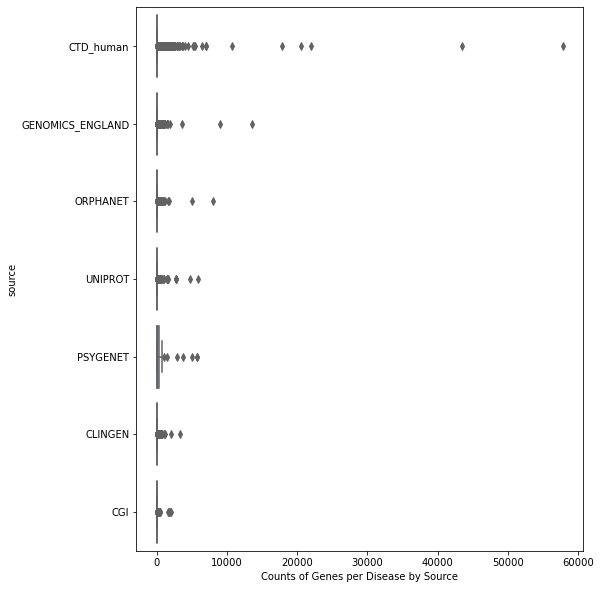

In [104]:
fig, ax = plt.subplots(figsize = (8,10))
sns.boxplot(y = 'source', x = 'Counts of Genes per Disease by Source',
                 data = SumDisease, palette="Set3", orient = 'h')

Text(0, 0.5, 'Frequency')

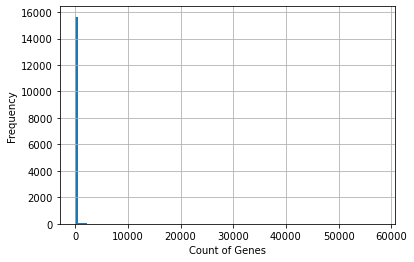

In [112]:
SumDisease['Counts of Genes per Disease by Source'].hist(bins=100)
plt.xlabel("Count of Genes", fontsize=10)
plt.ylabel("Frequency",fontsize=10)

In [113]:
SumDisease['Log of Counts of Genes per Disease by Source'] = np.log10(SumDisease['Counts of Genes per Disease by Source'])
SumDisease

,propagatedDOID,source,Counts of Genes per Disease by Source,Log of Counts of Genes per Disease by Source
2202,DOID:0001816,CTD_human,18,1.255273
5572,DOID:0001816,CGI,4,0.602060
11946,DOID:0002116,GENOMICS_ENGLAND,1,0.000000
11945,DOID:0002116,CTD_human,1,0.000000
261,DOID:0014667,UNIPROT,431,2.634477
...,...,...,...,...
7911,DOID:999,CGI,2,0.301030
7914,DOID:999,GENOMICS_ENGLAND,2,0.301030
2008,DOID:999,CTD_human,23,1.361728
3232,DOID:9993,CTD_human,10,1.000000


Text(0, 0.5, 'Frequency')

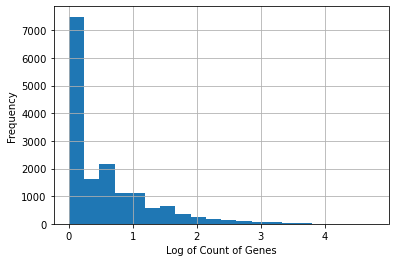

In [115]:
SumDisease['Log of Counts of Genes per Disease by Source'].hist(bins=20)
plt.xlabel("Log of Count of Genes", fontsize=10)
plt.ylabel("Frequency",fontsize=10)

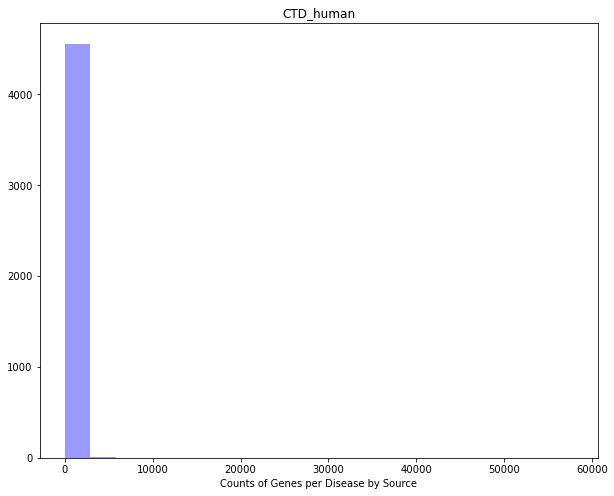

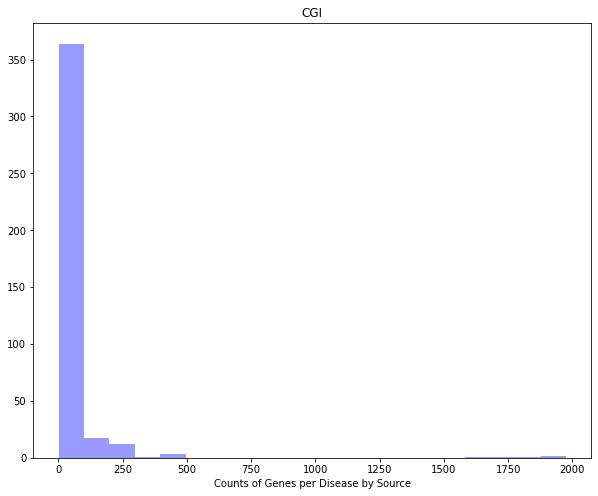

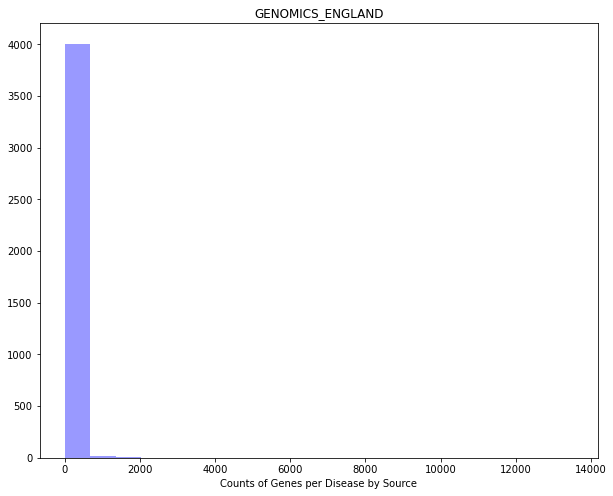

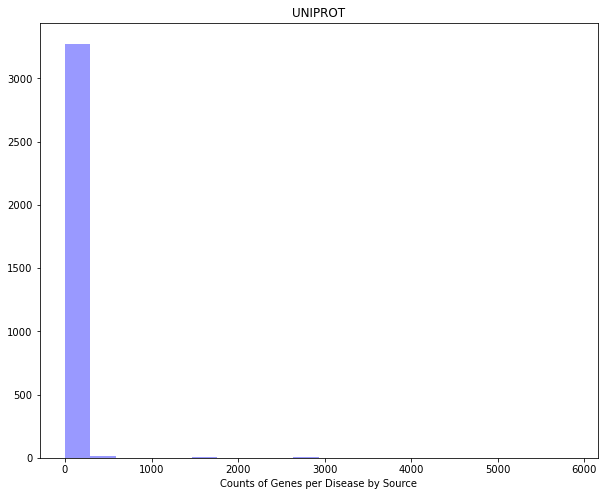

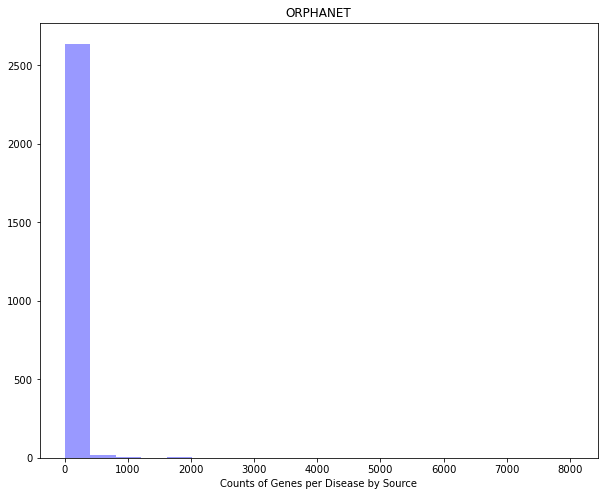

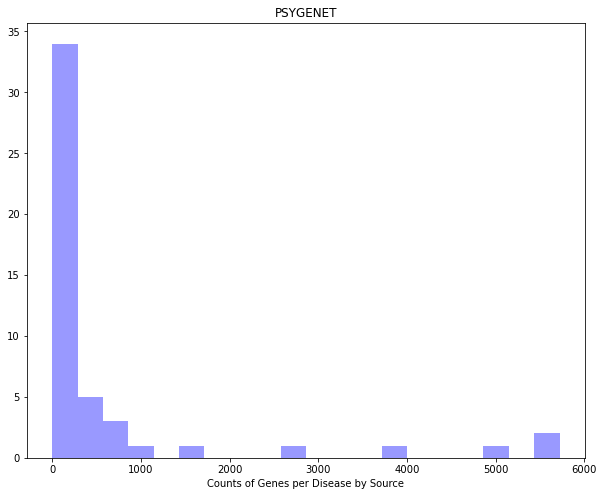

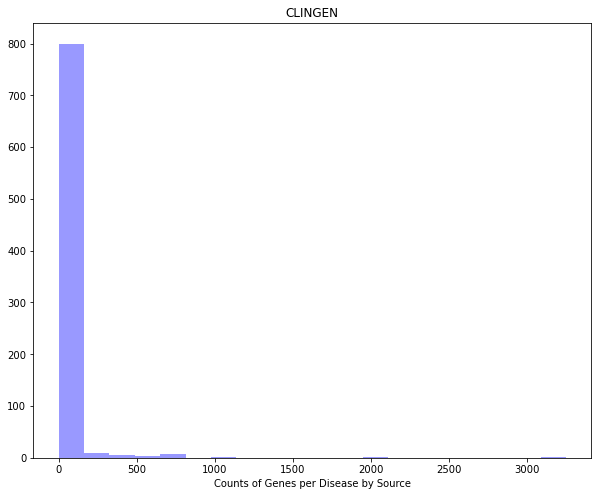

In [118]:
for i, source in enumerate(SumDisease.source.unique(), 1):
    data = SumDisease[SumDisease.source == source]
    fig, ax = plt.subplots(figsize = (10,8))
    sns.distplot(data['Counts of Genes per Disease by Source'], kde = False, color='blue', bins=20)
    plt.title(source)

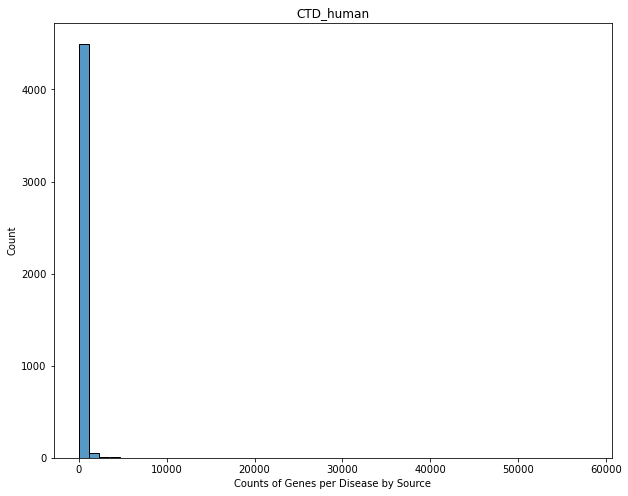

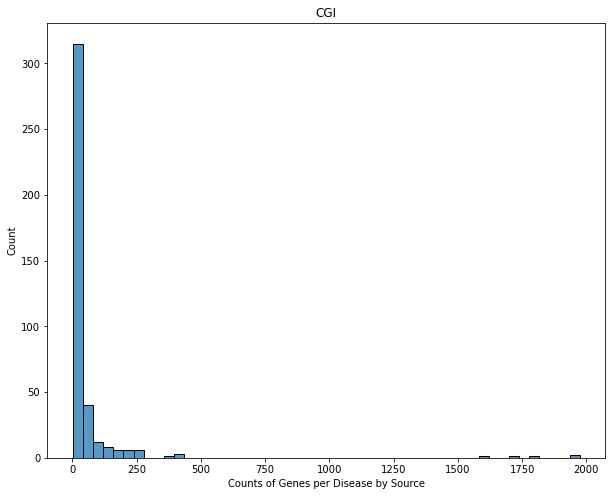

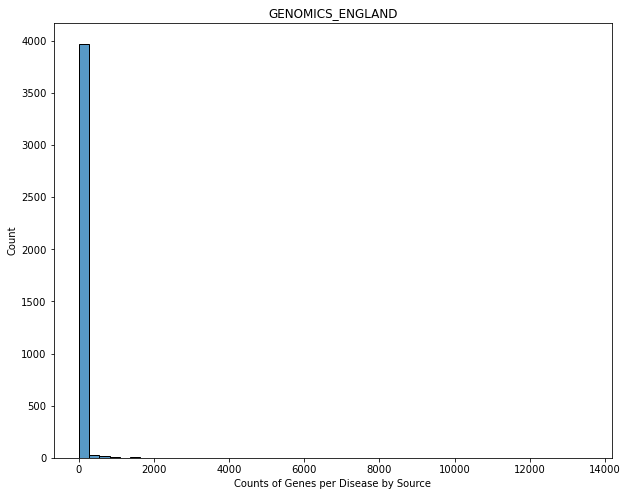

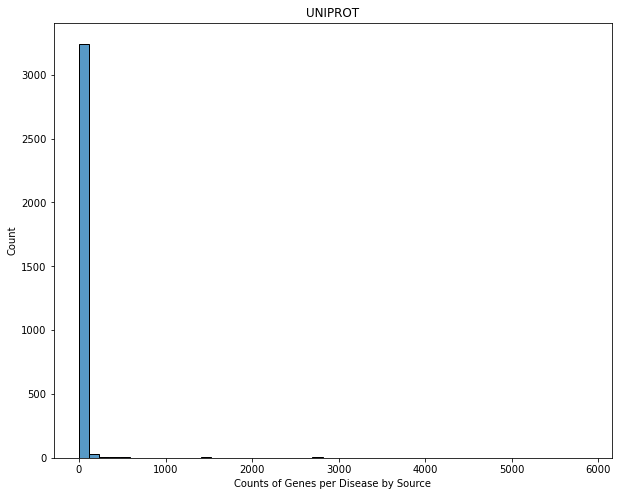

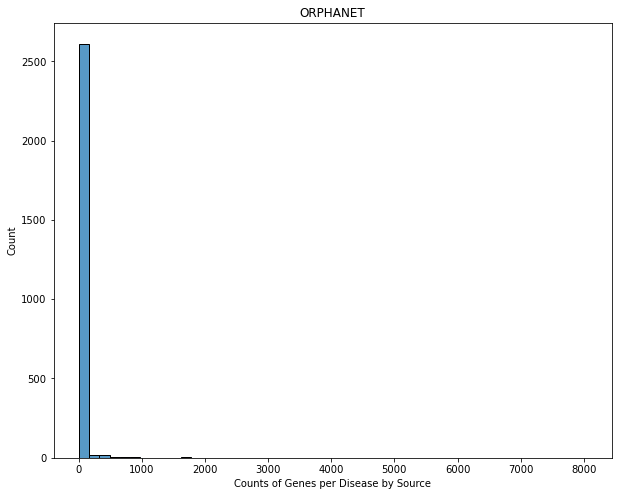

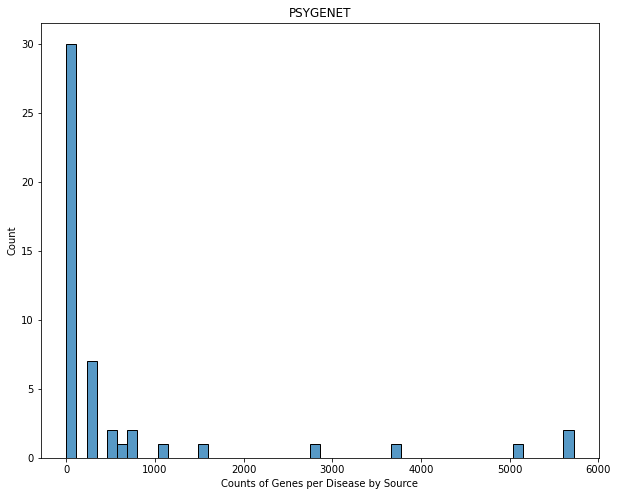

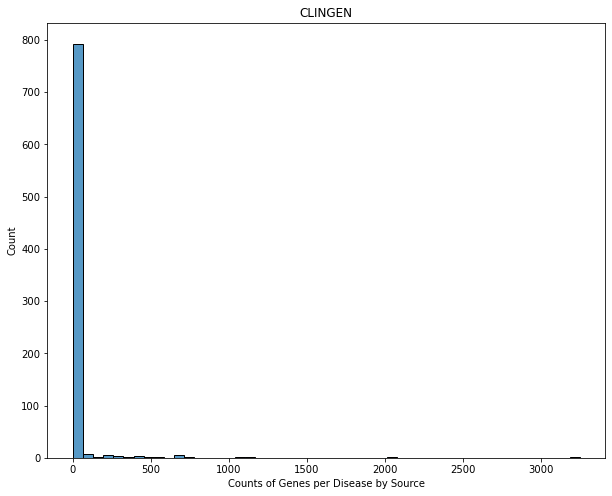

In [120]:
for i, source in enumerate(SumDisease.source.unique(), 1):
    data = SumDisease[SumDisease.source == source]
    fig, ax = plt.subplots(figsize = (10,8))
    sns.histplot(data['Counts of Genes per Disease by Source'], bins=50)
    plt.title(source)

In [121]:
SumDisease.to_csv('SumDisease.csv', index = False)

In [80]:
desired12['source'].unique()

array(['CLINGEN', 'UNIPROT', 'GENOMICS_ENGLAND', 'ORPHANET', 'CTD_human',
       'CGI'], dtype=object)

In [71]:
desired12

,DOID,diseaseName,source,geneId
1012,DOID:0050710,3-methylcrotonyl CoA carboxylase 1 deficiency,CLINGEN,"{56922, 64087}"
1016,DOID:0050710,3-methylcrotonyl CoA carboxylase 1 deficiency,UNIPROT,{56922}
1014,DOID:0050710,3-methylcrotonyl CoA carboxylase 1 deficiency,GENOMICS_ENGLAND,{56922}
1015,DOID:0050710,3-methylcrotonyl CoA carboxylase 1 deficiency,ORPHANET,"{56922, 64087}"
1013,DOID:0050710,3-methylcrotonyl CoA carboxylase 1 deficiency,CTD_human,{56922}
...,...,...,...,...
3047,DOID:0060574,"von Willebrand Disease, Type 2N",CTD_human,{7450}
12229,DOID:0111054,"von Willebrand Disease, Type 3",UNIPROT,{7450}
12227,DOID:0111054,"von Willebrand Disease, Type 3",CTD_human,{7450}
12228,DOID:0111054,"von Willebrand Disease, Type 3",GENOMICS_ENGLAND,{7450}


In [75]:
dict_of_sources = dict(iter(desired12.groupby('source')))
dict_of_sources['CLINGEN']

,DOID,diseaseName,source,geneId
1012,DOID:0050710,3-methylcrotonyl CoA carboxylase 1 deficiency,CLINGEN,"{56922, 64087}"
7742,DOID:0110009,ACHROMATOPSIA 7,CLINGEN,{22926}
3364,DOID:0060608,Aarskog syndrome,CLINGEN,{2245}
3391,DOID:0060609,Aarskog syndrome,CLINGEN,{2245}
18173,DOID:4480,Achondroplasia,CLINGEN,{2261}
...,...,...,...,...
12216,DOID:0111051,Thrombasthenia,CLINGEN,"{3674, 3690}"
12200,DOID:0111049,"Thrombasthenia-Thrombocytopenia, Hereditary",CLINGEN,{8328}
1061,DOID:0050725,Tyrosine Transaminase Deficiency Disease,CLINGEN,{6898}
15721,DOID:14717,X-linked centronuclear myopathy,CLINGEN,{4534}


In [74]:
desired12short = desired12.drop(columns = 'diseaseName')

In [76]:
dict_of_sources = dict(iter(desired12short.groupby('source')))
dict_of_sources['CLINGEN']

,DOID,source,geneId
1012,DOID:0050710,CLINGEN,"{56922, 64087}"
7742,DOID:0110009,CLINGEN,{22926}
3364,DOID:0060608,CLINGEN,{2245}
3391,DOID:0060609,CLINGEN,{2245}
18173,DOID:4480,CLINGEN,{2261}
...,...,...,...
12216,DOID:0111051,CLINGEN,"{3674, 3690}"
12200,DOID:0111049,CLINGEN,{8328}
1061,DOID:0050725,CLINGEN,{6898}
15721,DOID:14717,CLINGEN,{4534}


In [79]:
dict_of_sources

{'CGI':                DOID source                                             geneId
 18836     DOID:6367    CGI                                             {7015}
 19375     DOID:8761    CGI                                       {3718, 2623}
 2517   DOID:0060318    CGI                                       {6777, 4869}
 16493      DOID:234    CGI                                             {8438}
 18661     DOID:5672    CGI  {5378, 3845, 4233, 2956, 2064, 6416, 5395, 270...
 ...             ...    ...                                                ...
 14648     DOID:1240    CGI  {2176, 641, 1441, 2177, 2178, 2188, 2189, 5551...
 18693     DOID:5702    CGI                                {10818, 1019, 1021}
 17390     DOID:3382    CGI                                {10818, 1019, 1021}
 16569     DOID:2394    CGI  {898, 5378, 3845, 6794, 2956, 2064, 22800, 539...
 17924     DOID:4001    CGI  {898, 5378, 3845, 6794, 2956, 2064, 22800, 539...
 
 [238 rows x 3 columns],
 'CLINGEN':       

In [81]:
CLINGEN_dict = dict(zip(dict_of_sources['CLINGEN'].DOID, dict_of_sources['CLINGEN'].geneId))
CTD_human_dict = dict(zip(dict_of_sources['CTD_human'].DOID, dict_of_sources['CTD_human'].geneId))
CGI_dict = dict(zip(dict_of_sources['CGI'].DOID, dict_of_sources['CGI'].geneId))
GENOMICS_ENGLAND_dict = dict(zip(dict_of_sources['GENOMICS_ENGLAND'].DOID, dict_of_sources['GENOMICS_ENGLAND'].geneId))
UNIPROT_dict = dict(zip(dict_of_sources['UNIPROT'].DOID, dict_of_sources['UNIPROT'].geneId))
ORPHANET_dict = dict(zip(dict_of_sources['ORPHANET'].DOID, dict_of_sources['ORPHANET'].geneId))
#PSYGENET_dict = dict(zip(dict_of_sources['PSYGENET'].DOID, dict_of_sources['PSYGENET'].geneId))

In [99]:
CLINGEN_prop = disease_ontology.propagate(CLINGEN_dict)
CTD_human_dict = disease_ontology.propagate(CTD_human_dict)


In [96]:
from imp import reload
import ontology
reload(ontology)

<module 'ontology' from '/mnt/ufs18/home-087/f0102402/Arun_REU/ontology.py'>

In [100]:
CLINGEN_prop

{'DOID:0050710': {56922, 64087},
 'DOID:66': {58,
  59,
  70,
  215,
  362,
  472,
  538,
  540,
  580,
  633,
  673,
  675,
  781,
  783,
  785,
  845,
  916,
  999,
  1050,
  1073,
  1111,
  1281,
  1302,
  1387,
  1674,
  1687,
  1759,
  1786,
  1832,
  1834,
  2131,
  2155,
  2158,
  2159,
  2161,
  2175,
  2176,
  2189,
  2200,
  2201,
  2261,
  2299,
  2301,
  2316,
  2318,
  2395,
  2566,
  2707,
  2775,
  2812,
  2815,
  2956,
  3081,
  3265,
  3674,
  3690,
  3702,
  3752,
  3764,
  3766,
  3784,
  3845,
  3897,
  3912,
  4015,
  4043,
  4072,
  4087,
  4088,
  4144,
  4233,
  4292,
  4361,
  4436,
  4534,
  4595,
  4607,
  4624,
  4625,
  4627,
  4629,
  4633,
  4634,
  4638,
  4641,
  4647,
  4683,
  4703,
  4851,
  4893,
  4942,
  5172,
  5271,
  5290,
  5310,
  5311,
  5318,
  5350,
  5354,
  5395,
  5500,
  5592,
  5604,
  5605,
  5781,
  5889,
  5892,
  5894,
  5921,
  5922,
  5965,
  6016,
  6121,
  6204,
  6229,
  6237,
  6262,
  6323,
  6324,
  6327,
  6330,
  6335,
 

In [101]:
CLINGEN_dict

{'DOID:0050710': {58,
  59,
  70,
  215,
  362,
  472,
  538,
  540,
  580,
  633,
  673,
  675,
  781,
  783,
  785,
  845,
  916,
  999,
  1050,
  1073,
  1111,
  1281,
  1302,
  1387,
  1674,
  1687,
  1759,
  1786,
  1832,
  1834,
  2131,
  2155,
  2158,
  2159,
  2161,
  2175,
  2176,
  2189,
  2200,
  2201,
  2261,
  2299,
  2301,
  2316,
  2318,
  2395,
  2566,
  2707,
  2775,
  2812,
  2815,
  2956,
  3081,
  3265,
  3674,
  3690,
  3702,
  3752,
  3764,
  3766,
  3784,
  3845,
  3897,
  3912,
  4015,
  4043,
  4072,
  4087,
  4088,
  4144,
  4233,
  4292,
  4361,
  4436,
  4534,
  4595,
  4607,
  4624,
  4625,
  4627,
  4629,
  4633,
  4634,
  4638,
  4641,
  4647,
  4683,
  4703,
  4851,
  4893,
  4942,
  5172,
  5271,
  5290,
  5310,
  5311,
  5318,
  5350,
  5354,
  5395,
  5500,
  5592,
  5604,
  5605,
  5781,
  5889,
  5892,
  5894,
  5921,
  5922,
  5965,
  6016,
  6121,
  6204,
  6229,
  6237,
  6262,
  6323,
  6324,
  6327,
  6330,
  6335,
  6336,
  6497,
  6598,
  665